# Projet 3 consomation d'energie des batiments a Seatle
### Contexte :
Le projet de consommation d'énergie des bâtiments de Seattle vise à analyser et à comprendre les tendances de consommation d'énergie des batiment qui ne sont pas à usage d'habitation dans la ville de Seattle, en utilisant des données provenant d'une variété de bâtiments pour l'année 2016. Ces données comprennent des informations sur la consommation d'energie, le type d'energie,  les caractéristiques des bâtiments etc.

### Objectif :
L'objectif principal de ce projet est d'explorer les modèles de consommation d'énergie des bâtiments de Seattle à l'aide de techniques d'apprentissage supervisé.Nous chercherons à identifier les principales caractéristique qui influent sur la consommation d'énergie  et à développer des modèles prédictifs  pour estimer la consommation d'énergie future.

In [537]:

import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import missingno as msno
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import seaborn as sns
import sys
import time 
import folium
import folium.plugins


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [538]:
data = pd.read_csv("Data/2016_Building_Energy_Benchmarking.csv")


In [539]:
print("Taille du dataset", data.shape)

Taille du dataset (3376, 46)


In [540]:
# Liste des types de données pour chaque colonne
data_types = data.dtypes

# Sélectionner les colonnes catégorielles et numériques
categorical_columns = data_types[data_types == 'object'].index.tolist()
numeric_columns = data_types[data_types != 'object'].index.tolist()

# Afficher les résultats
display("Colonnes catégorielles : ", categorical_columns)
print("Nombre de colonnes catégorielles : ", len(categorical_columns))

display("\nColonnes numériques : ", numeric_columns)
print("Nombre de colonnes numériques : ", len(numeric_columns))

'Colonnes catégorielles : '

['BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'TaxParcelIdentificationNumber',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'YearsENERGYSTARCertified',
 'ComplianceStatus',
 'Outlier']

Nombre de colonnes catégorielles :  15


'\nColonnes numériques : '

['OSEBuildingID',
 'DataYear',
 'ZipCode',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

Nombre de colonnes numériques :  31


prédire les émissions de CO2 :  
TotalGHGEmissions
Définition : La quantité totale d'émission de gaz à effet de serre, y compris le dioxyde de   carbone, le méthane et l'oxyde nitreux, rejetée dans l'atmosphère à la suite de la consommation   d'énergie sur le site, mesurée en tonne d'équivalent dioxyde de carbone.  
prédire la consommation totale d’énergie de bâtiments :  
SiteEnergyUse(kBtu)  
Définition : La quantité annuelle d'énergie consommée par le bien, toutes sources d'énergie    confondues.  
Unité utilisée : kBtu --> Kilo British Thermal Units / Kilo d'unités thermiques britanniques  

In [541]:
data[['TotalGHGEmissions','GHGEmissionsIntensity']].describe()

TotalGHGEmissions  GHGEmissionsIntensity
count        3367.000000            3367.000000
mean          119.723971               1.175916
std           538.832227               1.821452
min            -0.800000              -0.020000
25%             9.495000               0.210000
50%            33.920000               0.610000
75%            93.940000               1.370000
max         16870.980000              34.090000

dans un premier temps pour cette l'analyse, nous effectuons les vérifications suivantes :

1. Vérifier que tous les bâtiments sont situés à Seattle.
2. Vérifier que toutes les années correspondent à 2016.
3. Vérifier le nombre de bâtiments et supprimer ceux qui ont un nombre d'étages égal à 0.
4. Vérifier que tous les bâtiments ne sont pas des habitations.
5. Vérifier les outliers
6. Vérifier s'il y a des doublons dans la colonne "OSEBuildingID".



Veriffier les outliers pour les variables TotalGHGEmissions et GHGEmissionsIntensity 

In [542]:
#Type des Variables
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

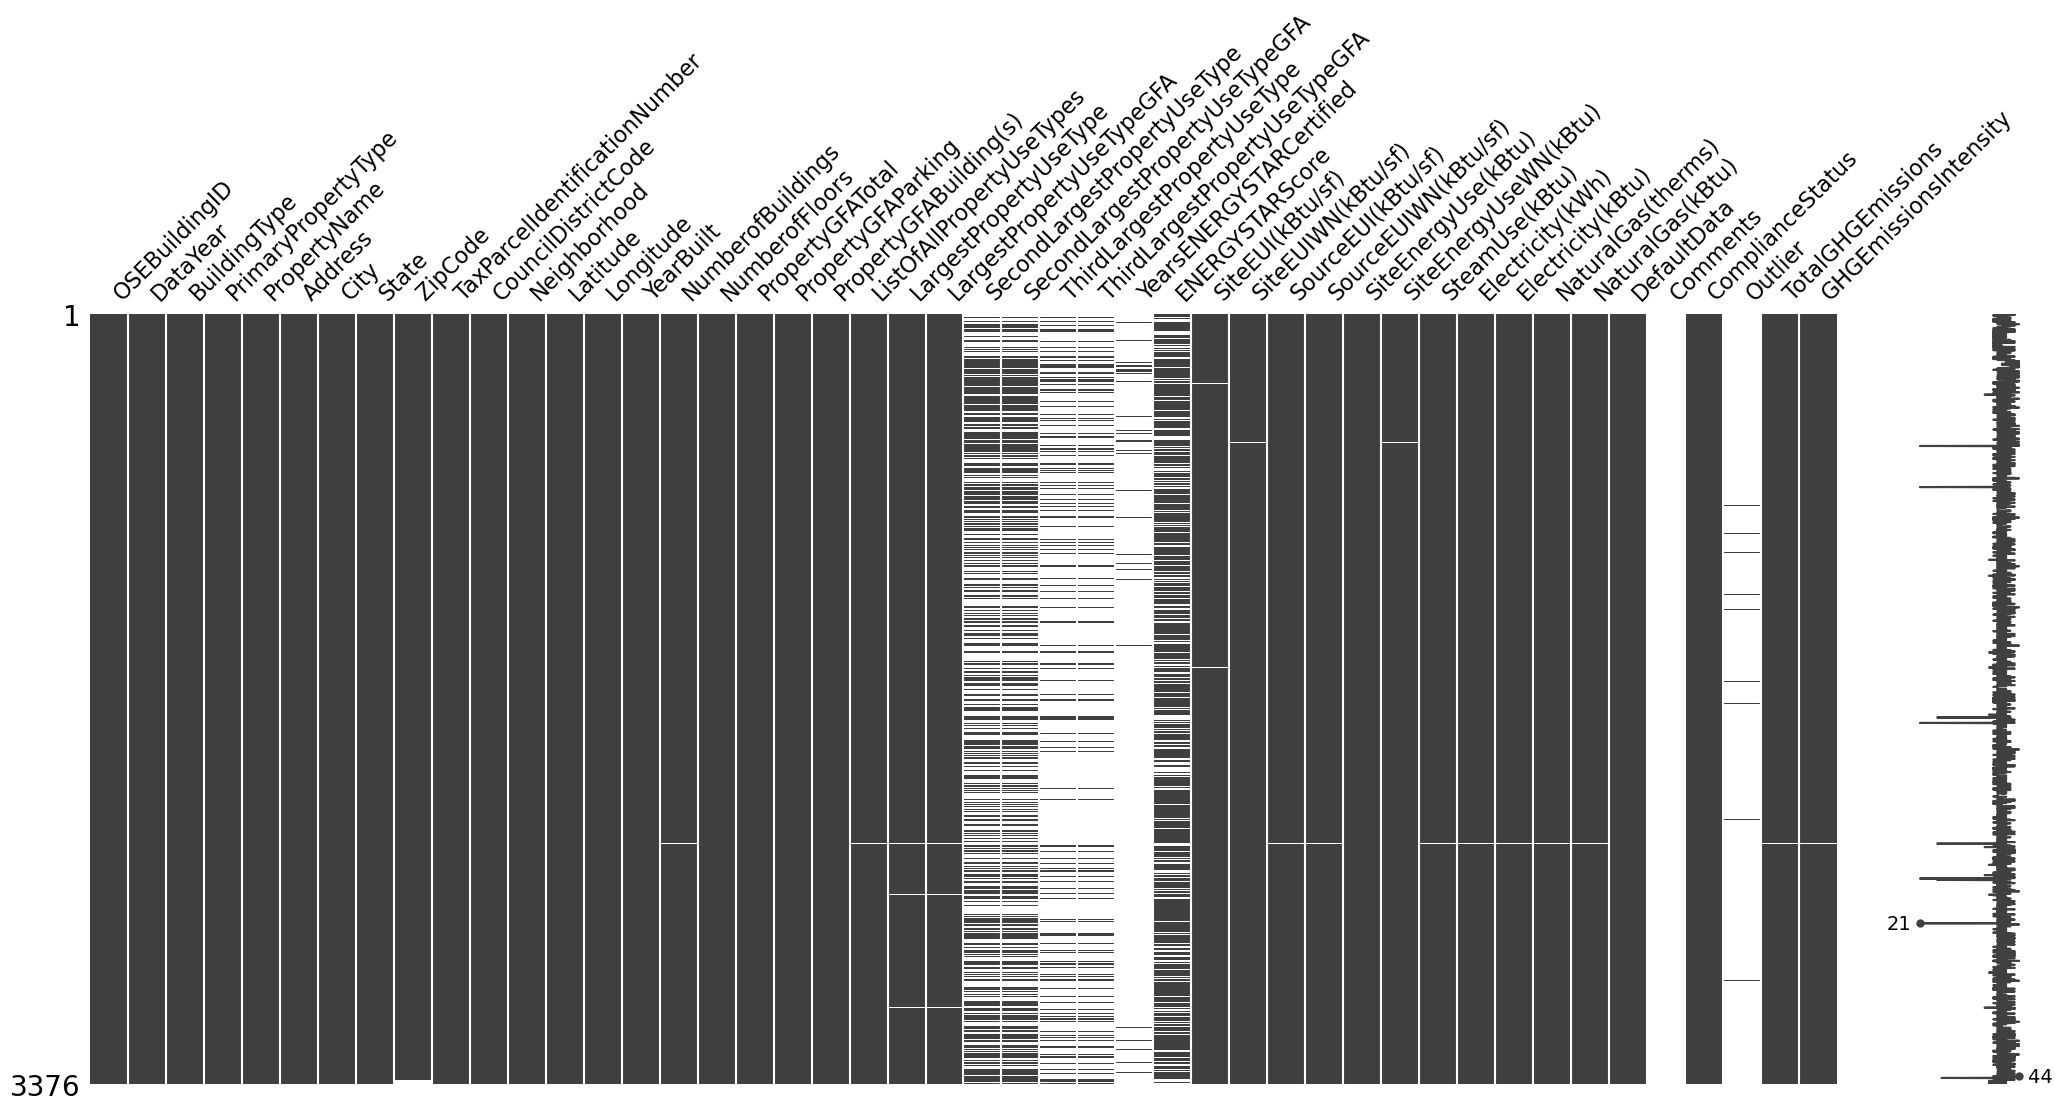

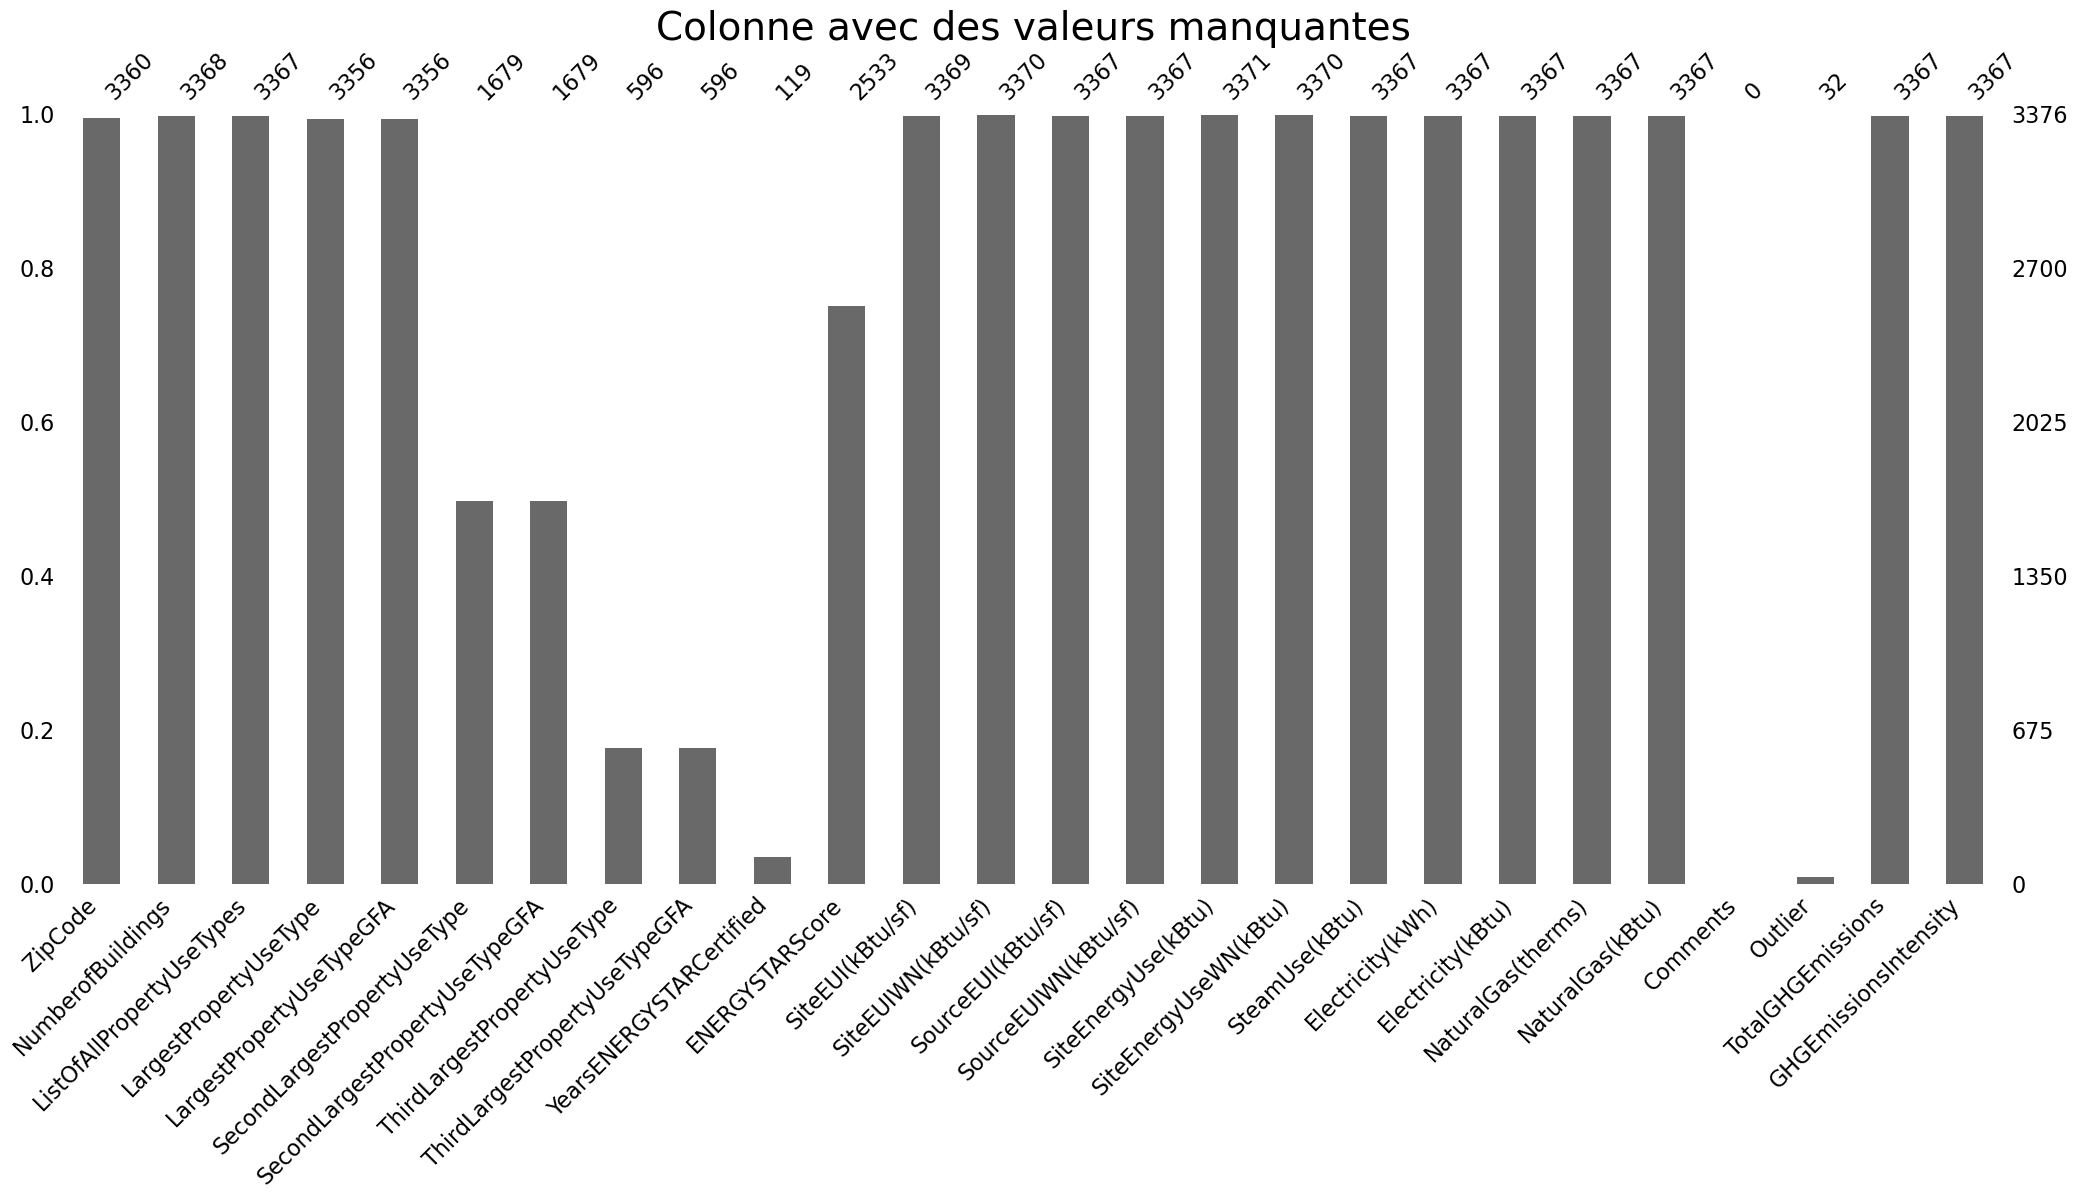

In [543]:
msno.matrix(data)
plt.show()

msno.bar(data[data.columns[data.isnull().any()]])
plt.title("Colonne avec des valeurs manquantes", fontsize=28)
plt.show()


Les données manquantes dans ce jeu de données sont principalement localisées dans les colonnes qui concernent les différentes utilisations des bâtiments, telles que la deuxième plus grande utilisation de la propriété (SecondLargestPropertyUseType) et la troisième plus grande utilisation de la propriété (ThirdLargestPropertyUseType). Le manque de ces valeurs peut s'expliquer par le fait que certains bâtiments ne possèdent pas de deuxième ou troisième propriété d'utilisation.

In [544]:
print(data.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

 ### Visualisation et emplacement des batiments


In [545]:
fig = px.scatter_mapbox(data, lat="Latitude", lon="Longitude", hover_name='PropertyName', color = "SiteEUI(kBtu/sf)"
                       ,color_continuous_scale="viridis", zoom = 10, title= "Répartition des bâtiments et leur consomation" )
fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(title = "Répartition de la consomation  en énergie des bâtiments dans la ville de Seattle" )
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

In [546]:

#Coordonnées du centre de Seattle
seattle_lat = 47.6062
seattle_lon = -122.3321

seattle = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11)

#Clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle)
for lat, lon, in zip(data.Latitude, data.Longitude):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

seattle

### Age des batiments
Création d'une variable pour connaitre l'age du batiment.

In [547]:
data["BuildingAge"] = data["DataYear"] - data["YearBuilt"]
display(data[["BuildingAge", "DataYear", "YearBuilt"]].max())


BuildingAge     116
DataYear       2016
YearBuilt      2015
dtype: int64

L'année de construction la plus récente est 2015. les batiments les plus recents avait donc 1 an en 1016.  
Le batiment le plus vieux avait 116 ans en 2016.

### Nombre de batiment

In [548]:
display(data.NumberofBuildings.value_counts(ascending= False))

NumberofBuildings
1.0      3175
0.0        92
2.0        37
3.0        22
4.0        12
5.0        10
6.0         5
8.0         3
10.0        2
14.0        2
9.0         2
7.0         1
11.0        1
16.0        1
23.0        1
27.0        1
111.0       1
Name: count, dtype: int64

 Il y a 92 propriétés avec un résultat de 0 bâtiment, ce qui n'est pas possible. Il est nécessaire de vérifier cette donnée.

De plus, dans la colonne "NumberOfBuildings", on peut observer qu'il y a un lieu avec 111 bâtiments. Il s'agit peut-être d'une valeur extrême qui nécessite une vérification supplémentaire.


In [549]:
Bat_111 = data.loc[data["NumberofBuildings"] == 111]
display(Bat_111)

OSEBuildingID  DataYear BuildingType PrimaryPropertyType  \
3274          49967      2016       Campus          University   

                                   PropertyName                    Address  \
3274  University of Washington - Seattle Campus  NE 45th St & Brooklyn Ave   

         City State  ZipCode TaxParcelIdentificationNumber  \
3274  Seattle    WA  98105.0                    1625049001   

      CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
3274                    4    NORTHEAST  47.65644 -122.31041       1900   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3274              111.0               0           9320156                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3274                 9320156        College/University     College/University   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3274                  9320156.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3274                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3274                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3274              NaN         93.800003                 0.0   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3274          246.600006                   0.0          873923712.0   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3274                    0.0      84985240.0       192577488.0   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3274        657074389.0                 0.0               0.0        False   

      Comments ComplianceStatus Outlier  TotalGHGEmissions  \
3274       NaN        Compliant     NaN           11140.56   

      GHGEmissionsIntensity  BuildingAge  
3274                    1.2          116

Le lieux qui possede 111 batiments est University of Washington - Seattle Campus

In [550]:
Bat_0 = data.loc[data["NumberofBuildings"] == 0]
display(Bat_0.shape)

data["NumberofBuildings"]= data["NumberofBuildings"].replace(0,1)

(92, 47)

Il y a 92 lieux qui possede 0 batiments apres en avoir verifier une bonne partie sur internet c'est souvent un batiment unique. j'ai donc décider de remplacer ces 0 par 1.

### Nombre d'étage

In [551]:
value_counts_sorted = data['NumberofFloors'].value_counts().sort_index(ascending=False)

print(value_counts_sorted[:10])

NumberofFloors
99    1
76    1
63    1
56    1
55    1
49    1
47    1
46    1
42    6
41    3
Name: count, dtype: int64


In [552]:
Floor_99 = data.loc[data["NumberofFloors"] >= 40]
display(Floor_99.head())

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
2                3      2016  NonResidential               Hotel   
221            345      2016  NonResidential        Large Office   
222            346      2016  NonResidential        Large Office   
229            353      2016  NonResidential        Large Office   
231            355      2016  NonResidential        Large Office   

                PropertyName                     Address     City State  \
2    5673-The Westin Seattle             1900 5th Avenue  Seattle    WA   
221         999 Third Avenue  999 3rd Avenue, Suite 1550  Seattle    WA   
222       1000 Second Avenue          1000 Second Avenue  Seattle    WA   
229             Safeco Plaza          1001 Fourth Avenue  Seattle    WA   
231         901 Fifth Avenue            901 Fifth Avenue  Seattle    WA   

     ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
2    98101.0                    0659000475                    7     DOWNTOWN   
221  98104.0                    0939000435                    7     DOWNTOWN   
222  98104.0                    0939000475                    7     DOWNTOWN   
229  98154.0                    0942000300                    7     DOWNTOWN   
231  98164.0                    0942000365                    7     DOWNTOWN   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
2    47.61393 -122.33810       1969                1.0              41   
221  47.60505 -122.33427       1983                1.0              47   
222  47.60567 -122.33511       1986                1.0              41   
229  47.60615 -122.33388       1969                1.0              49   
231  47.60616 -122.33165       1973                1.0              42   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
2              956110              196718                  759392   
221           1323055                   0                 1323055   
222            589921              129432                  460489   
229           1123435              368980                  754455   
231            617684              171500                  446184   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
2                                                Hotel                  Hotel   
221                        Office, Parking, Restaurant                 Office   
222                Office, Parking, Pre-school/Daycare                 Office   
229  Financial Office, Food Sales, Office, Other, P...                 Office   
231    Financial Office, Office, Parking, Retail Store                 Office   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
2                     756493.0                          NaN   
221                  1011135.0                      Parking   
222                   470416.0                      Parking   
229                   808980.0                      Parking   
231                   581558.0                      Parking   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
2                                NaN                         NaN   
221                         272682.0                  Restaurant   
222                         107667.0          Pre-school/Daycare   
229                         232248.0                       Other   
231                         189600.0                Retail Store   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
2                               NaN                      NaN             43.0   
221                         37595.0                      NaN             94.0   
222                         10290.0                 20162015             84.0   
229                         30329.0     20162015201420122008             89.0   
231                         18026.0             201520142013             28.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf) 

Après verification sur internet:  
Batiment de 99 etage : il s'agit bien d'une eglise ne possédant qu'un seul étage. 
les autres Batiments ayant plus de 40 etages sont des tours. Il s'agit la plupart du temps de bureau ou d'hotel mais il y a aussi des batiments residentiels.

### Doublons

In [553]:

doublons_present = data["OSEBuildingID"].duplicated().any()

if doublons_present:
    print(f"La colonne OSEBuildingID contient des doublons.")
else:
    print(f"La colonne OSEBuildingID ne contient pas de doublons.")


La colonne OSEBuildingID ne contient pas de doublons.


### Identification de l'utilisation des batiments

In [554]:
data.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

<font color=#F7DC6F>Il y a des batiment a usage d'habitation (Multifamily).  
Comme cette étude ne concerne que les batiments a usage non résidentiel il faut les identifier </font> 

In [555]:
family_buildings = data.BuildingType.str.contains("Multifamily")
print("Le nombre de bâtiment résidentiels est ", len(data[family_buildings]))
display(data[family_buildings].head())

Le nombre de bâtiment résidentiels est  1708


OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
9               13      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
165            265      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
173            280      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
188            296      2016  Multifamily LR (1-4)  Low-Rise Multifamily   
189            297      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   

                     PropertyName               Address     City State  \
9                   Lyon Building        607 - 3rd Ave.  Seattle    WA   
165        YWCA Opportunity Place       2024 3rd Avenue  Seattle    WA   
173                      Wintonia        1431 Minor Ave  Seattle    WA   
188  Cooper School Artist's Lofts  4408 Delridge Way SW  Seattle    WA   
189               LAKE CITY COURT     12730 33RD AVE NE  Seattle    WA   

     ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
9    98104.0                    0939000105                    7     DOWNTOWN   
165  98121.0                    8729690000                    7     DOWNTOWN   
173  98101.0                    8725600350                    7         EAST   
188  98106.0                    3388120000                    1     DELRIDGE   
189  98125.0                    3993000000                    5        NORTH   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
9    47.60284 -122.33184       1910                1.0               6   
165  47.61316 -122.34153       2003                1.0               7   
173  47.61360 -122.32785       1909                1.0               6   
188  47.56379 -122.36301       1917                1.0               4   
189  47.72232 -122.29181       2009                1.0               6   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
9               63712                1496                   62216   
165            116947                   0                  116947   
173             51976                   0                   51976   
188             56617                   0                   56617   
189             56745                   0                   56745   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
9                                  Multifamily Housing    Multifamily Housing   
165  Multifamily Housing, Office, Other - Lodging/R...    Multifamily Housing   
173                                Multifamily Housing    Multifamily Housing   
188                                Multifamily Housing    Multifamily Housing   
189                                Multifamily Housing    Multifamily Housing   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
9                      56132.0                          NaN   
165                    81740.0                       Office   
173                    50350.0                          NaN   
188                    56617.0                          NaN   
189                    43673.0                          NaN   

     SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseType  \
9                                NaN                          NaN   
165                          27403.0  Other - Lodging/Residential   
173                              NaN                          NaN   
188                              NaN                          NaN   
189                              NaN                          NaN   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
9                               NaN                      NaN              1.0   
165                         12851.0                      NaN              NaN   
173                             NaN                      NaN             34.0   
188                             NaN                      NaN             15.0   
189                             NaN                      NaN             54.

<font color=#F7DC6F>il y a 1708 batiment a usage d'habitation on peut les supprimer des maintenant </font> 

In [556]:
data = data.loc[~data['BuildingType'].str.contains('Multifamily', case=False)]
print(data.shape)

(1668, 47)


### Outliers

In [557]:
outlier = data.loc[data['Outlier'].isna()== False]
display(outlier.shape)

(17, 47)

In [558]:
# Supprimer les Outliers du DataFrame
data = data.loc[data['Outlier'].isna()==True]
print(data.shape)

(1651, 47)


### Données Manquante

In [559]:

data =data.drop(labels=["Address",'City', 'State', 'ZipCode','DefaultData','CouncilDistrictCode',
                       'Electricity(kWh)' ,'NaturalGas(therms)',
                       'SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)',
                       'DataYear','PropertyName',
                       'YearBuilt'], axis=1)



Les colonnes Longitude et Latitude sufise pour localiser les batiment, on peut donc supprimer les autres données de localisation.  
Nous choississons de travailler avec le kBtu : British thermal unit.  
Nous pouvons donc supprimer les variables lié aux autre unité d'energie:  
(kWh : kilowattheure  
Therm : correspond approximativement à l'énergie libérée par la combustion de 2 kg (approx. 3 l) d'essence.)   
 
Les variables ayant comme sufixe "WN" sont des données predites sur 30 ans en fonction d'une météo normale.  
Comme on a crée une variable indiquant l'age du batiment on peut suprimer 'YearBuilt' et 'DataYear'(2016)



### Valeurs manquantes

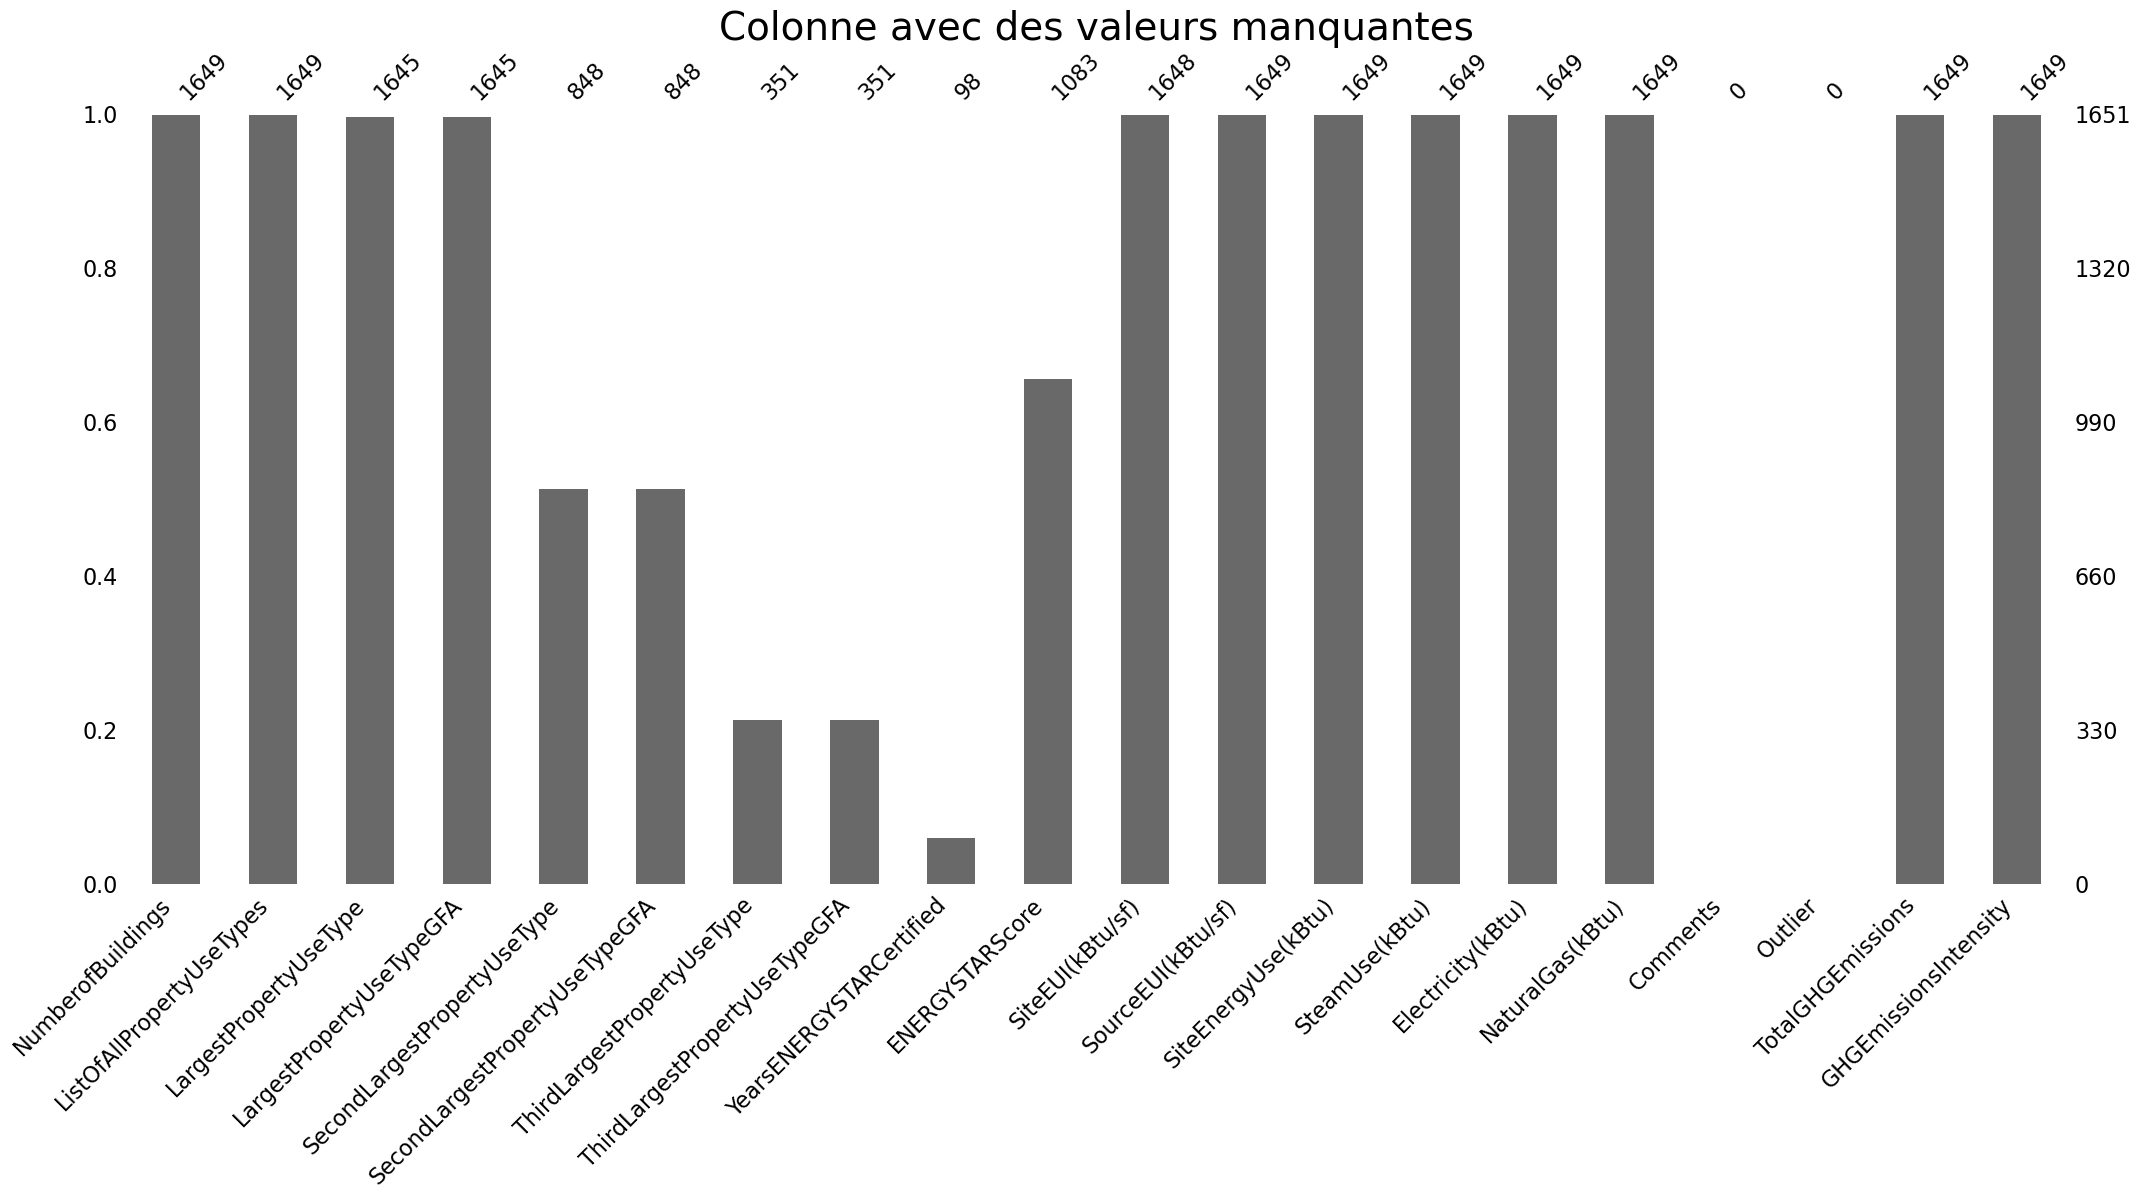

In [560]:

msno.bar(data[data.columns[data.isnull().any()]])
plt.title("Colonne avec des valeurs manquantes", fontsize=28)
plt.show()


In [561]:
# Nombre de valeurs manquantes et pourcentage de valeurs manquantes
def missing_stats(df):
    total_missing = df.isnull().sum()
    percent_missing = (total_missing / len(df)) * 100
    return pd.DataFrame({'Total Missing': total_missing, 'Percentage Missing': percent_missing})

# Appliquer la fonction pour chaque colonne
missing_info = missing_stats(data)

# Afficher le résultat
print("Informations sur les valeurs manquantes par colonne:")
display(missing_info.loc[missing_info['Percentage Missing']>=80])


Informations sur les valeurs manquantes par colonne:


Total Missing  Percentage Missing
YearsENERGYSTARCertified           1553           94.064204
Comments                           1651          100.000000
Outlier                            1651          100.000000

On peut supprimer les colonnes qui ont plus de 80% de valeurs manquantes

In [562]:
# Supprimer les colonnes avec plus de 80% de valeurs manquantes
threshold = 80
columns_to_drop = missing_info[missing_info['Percentage Missing'] > threshold].index
display(columns_to_drop)
data = data.drop(columns=columns_to_drop)

# Afficher le nouveau DataFrame
print(data.columns)

Index(['YearsENERGYSTARCertified', 'Comments', 'Outlier'], dtype='object')

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType',
       'TaxParcelIdentificationNumber', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'BuildingAge'],
      dtype='object')


In [563]:
missing_stats(data)

Total Missing  Percentage Missing
OSEBuildingID                                0            0.000000
BuildingType                                 0            0.000000
PrimaryPropertyType                          0            0.000000
TaxParcelIdentificationNumber                0            0.000000
Neighborhood                                 0            0.000000
Latitude                                     0            0.000000
Longitude                                    0            0.000000
NumberofBuildings                            2            0.121139
NumberofFloors                               0            0.000000
PropertyGFATotal                             0            0.000000
PropertyGFAParking                           0            0.000000
PropertyGFABuilding(s)                       0            0.000000
ListOfAllPropertyUseTypes                    2            0.121139
LargestPropertyUseType                       6            0.363416
LargestPropertyUseTypeGFA                    6            0.363416
SecondLargestPropertyUseType               803           48.637190
SecondLargestPropertyUseTypeGFA            803           48.637190
ThirdLargestPropertyUseType               1300           78.740157
ThirdLargestPropertyUseTypeGFA            1300           78.740157
ENERGYSTARScore                            568           34.403392
SiteEUI(kBtu/sf)                             3            0.181708
SourceEUI(kBtu/sf)                           2            0.121139
SiteEnergyUse(kBtu)                          2            0.121139
SteamUse(kBtu)                               2            0.121139
Electricity(kBtu)                            2            0.121139
NaturalGas(kBtu)                             2            0.121139
ComplianceStatus                             0            0.000000
TotalGHGEmissions                            2            0.121139
GHGEmissionsIntensity                        2            0.121139
BuildingAge                                  0            0.000000

In [564]:
data = data.dropna(subset=['TotalGHGEmissions']) ### je veux absolument avoir cette information (targuet)
data = data.dropna(subset=['GHGEmissionsIntensity']) ### je veux absolument avoir cette information (targuet)
data = data.dropna(subset=['SiteEUI(kBtu/sf)']) ### je veux absolument avoir cette information (targuet)


In [565]:
print(data.loc[:,"Neighborhood"].unique())
data.loc[:, "Neighborhood"] = data.loc[:, "Neighborhood"].apply(lambda x: x.upper()) 

data.loc[:, "Neighborhood" ].replace('DELRIDGE NEIGHBORHOODS','DELRIDGE', inplace = True)
print(data.loc[:,"Neighborhood"].unique())

['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE']


### PrimaryPropertyType

In [566]:
data = data.dropna(subset=['ListOfAllPropertyUseTypes']) # supprimer quand on n'a pas la donné
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].fillna('no information') # remplacer les NAn pas no informartion
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna('no information') 
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].fillna('no information') 


In [567]:
data.SecondLargestPropertyUseTypeGFA.fillna(value = 0, inplace =True)
data["ThirdLargestPropertyUseTypeGFA"].fillna(value = 0, inplace = True)

In [568]:
data.shape

(1648, 30)

In [569]:
data.PrimaryPropertyType.unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily',
       'Office'], dtype=object)

In [570]:

data.loc[:,"PrimaryPropertyType"] = data.loc[:,"PrimaryPropertyType"].replace('Supermarket / Grocery Store','Supermarket/Grocery Store')

In [571]:
missing_stats(data)

Total Missing  Percentage Missing
OSEBuildingID                                0            0.000000
BuildingType                                 0            0.000000
PrimaryPropertyType                          0            0.000000
TaxParcelIdentificationNumber                0            0.000000
Neighborhood                                 0            0.000000
Latitude                                     0            0.000000
Longitude                                    0            0.000000
NumberofBuildings                            0            0.000000
NumberofFloors                               0            0.000000
PropertyGFATotal                             0            0.000000
PropertyGFAParking                           0            0.000000
PropertyGFABuilding(s)                       0            0.000000
ListOfAllPropertyUseTypes                    0            0.000000
LargestPropertyUseType                       0            0.000000
LargestPropertyUseTypeGFA                    4            0.242718
SecondLargestPropertyUseType                 0            0.000000
SecondLargestPropertyUseTypeGFA              0            0.000000
ThirdLargestPropertyUseType                  0            0.000000
ThirdLargestPropertyUseTypeGFA               0            0.000000
ENERGYSTARScore                            565           34.283981
SiteEUI(kBtu/sf)                             0            0.000000
SourceEUI(kBtu/sf)                           0            0.000000
SiteEnergyUse(kBtu)                          0            0.000000
SteamUse(kBtu)                               0            0.000000
Electricity(kBtu)                            0            0.000000
NaturalGas(kBtu)                             0            0.000000
ComplianceStatus                             0            0.000000
TotalGHGEmissions                            0            0.000000
GHGEmissionsIntensity                        0            0.000000
BuildingAge                                  0            0.000000

In [572]:
data.describe()

OSEBuildingID     Latitude    Longitude  NumberofBuildings  \
count    1648.000000  1648.000000  1648.000000        1648.000000   
mean    16318.385316    47.616190  -122.332938           1.199636   
std     13852.649715     0.048288     0.024618           2.938483   
min         1.000000    47.499170  -122.411820           1.000000   
25%       580.750000    47.585385  -122.343335           1.000000   
50%     21140.500000    47.612480  -122.332895           1.000000   
75%     24600.250000    47.649760  -122.321748           1.000000   
max     50226.000000    47.733870  -122.258640         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     1648.000000      1.648000e+03         1648.000000   
mean         4.135922      1.187974e+05        13012.990898   
std          6.599091      2.973748e+05        42501.407369   
min          0.000000      1.128500e+04            0.000000   
25%          1.000000      2.952075e+04            0.000000   
50%          2.000000      4.971200e+04            0.000000   
75%          4.000000      1.060102e+05            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            1.648000e+03               1.644000e+03   
mean             1.057844e+05               9.870753e+04   
std              2.840589e+05               2.771000e+05   
min              3.636000e+03               5.656000e+03   
25%              2.852325e+04               2.564175e+04   
50%              4.755700e+04               4.403900e+04   
75%              9.506750e+04               9.203675e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1648.000000                     1648.000000   
mean                      18612.421903                     3178.452912   
std                       50965.388199                    18069.624211   
min                           0.000000                        0.000000   
25%                           0.000000                        0.000000   
50%                           0.000000                        0.000000   
75%                       12691.000000                        0.000000   
max                      639931.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
count      1083.000000       1648.000000         1648.000000   
mean         65.191136         72.449211          176.455886   
std          28.376486         73.730681          184.329098   
min           1.000000          0.000000            0.000000   
25%          48.000000         34.074999           77.800003   
50%          73.000000         52.099998          131.500000   
75%          89.000000         81.749998          204.225006   
max         100.000000        834.400024         2620.000000   

       SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
count         1.648000e+03    1.648000e+03       1.648000e+03   
mean          8.480184e+06    5.181711e+05       5.864566e+06   
std           3.038392e+07    5.543731e+06       2.087933e+07   
min           0.000000e+00    0.000000e+00      -1.154170e+05   
25%           1.253390e+06    0.000000e+00       7.295842e+05   
50%           2.584402e+06    0.000000e+00       1.633206e+06   
75%           6.928335e+06    0.000000e+00       4.882877e+06   
max           8.739237e+08    1.349435e+08       6.570744e+08   

       NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  BuildingAge  
count      1.648000e+03        1648.000000            1648.000000  1648.000000  
mean       1.990820e+06         186.613246               1.622294    53.816748  
std        9.419842e+06         755.850359               2.344802    32.630762  
min        0.000000e+00          -0.800000              -0.020000     1.000000  
25%        0.000000e+00          20.60000

<font color="red">il y a des valeurs d'emission inferieur à 0 dans:Electricity(kBtu), TotalGHGEmission,GHGEmissionsIntensity</font> 

In [573]:
outlier_neg = data.loc[(data['Electricity(kBtu)'] < 0) | (data['TotalGHGEmissions'] < 0) | (data['GHGEmissionsIntensity'] < 0)]
display(outlier_neg)
data = data.drop(index=3206)
outlier_neg.shape

OSEBuildingID    BuildingType          PrimaryPropertyType  \
3206          49784  NonResidential  Small- and Mid-Sized Office   

     TaxParcelIdentificationNumber Neighborhood  Latitude  Longitude  \
3206                    7234600195      CENTRAL  47.61432 -122.31257   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3206                1.0               6             52000                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3206                   52000                    Office                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3206                    48159.0               no information   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3206                              0.0              no information   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
3206                             0.0            100.0               7.1   

      SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
3206                 2.0          342726.0938             0.0   

      Electricity(kBtu)  NaturalGas(kBtu) ComplianceStatus  TotalGHGEmissions  \
3206          -115417.0               0.0        Compliant               -0.8   

      GHGEmissionsIntensity  BuildingAge  
3206                  -0.02            3

(1, 30)

In [574]:
SiteEU0 = data.loc[data['SiteEnergyUse(kBtu)'] == 0 ]
display(SiteEU0.shape,SiteEU0)
display(data.loc[data['ComplianceStatus']== 'Missing Data'].shape)

(15, 30)

OSEBuildingID       BuildingType PrimaryPropertyType  \
28               34  SPS-District K-12         K-12 School   
31               37  SPS-District K-12         K-12 School   
62               87  SPS-District K-12         K-12 School   
81              118  SPS-District K-12         K-12 School   
85              122  SPS-District K-12         K-12 School   
95              140  SPS-District K-12         K-12 School   
133             217  SPS-District K-12         K-12 School   
139             227  SPS-District K-12         K-12 School   
152             242  SPS-District K-12         K-12 School   
614             820  SPS-District K-12         K-12 School   
630             850  SPS-District K-12         K-12 School   
746           19776     NonResidential               Other   
1361          21616  SPS-District K-12         K-12 School   
1894          23722  SPS-District K-12         K-12 School   
3166          49703  SPS-District K-12         K-12 School   

     TaxParcelIdentificationNumber           Neighborhood  Latitude  \
28                      0688000090                CENTRAL  47.62266   
31                      0809000005  MAGNOLIA / QUEEN ANNE  47.63290   
62                      2518400005              SOUTHWEST  47.50970   
81                      1324039116               DELRIDGE  47.56360   
85                      1524049002              SOUTHEAST  47.57324   
95                      1931301145             LAKE UNION  47.65464   
133                     3526039131                BALLARD  47.69675   
139                     3646100540                CENTRAL  47.59796   
152                     5100404840                  NORTH  47.69823   
614                     0007600137                CENTRAL  47.60120   
630                     3416600240                CENTRAL  47.60210   
746                     0164000020              NORTHWEST  47.72777   
1361                    2126049041                  NORTH  47.72369   
1894                    3526039024                BALLARD  47.69497   
3166                    2225039016  MAGNOLIA / QUEEN ANNE  47.64342   

      Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
28   -122.30547                1.0               1            126351   
31   -122.35172                1.0               2             51582   
62   -122.37759                1.0               2             53352   
81   -122.35800                1.0               3             74468   
85   -122.29058                1.0               2             58933   
95   -122.34912                1.0               3             66588   
133  -122.37760                1.0               1            160270   
139  -122.30415                1.0               3            136188   
152  -122.32126                1.0               2             52792   
614  -122.31548                1.0               1             52924   
630  -122.29181                1.0               3             55353   
746  -122.34503                1.0               1             29924   
1361 -122.30676                1.0               1             42292   
1894 -122.38704                1.0               1             39971   
3166 -122.39970                1.0               1            116101   

      PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
28                     0                  126351               K-12 School   
31                     0                   51582               K-12 School   
62                     0                   53352               K-12 School   
81                     0                   74468               K-12 School   
85                     0                   58933               K-12 School   
95                     0                   66588               K-12 School   
133                    0                  160270               K-12 School   
139                    0                  136188               K-12 School   
152                  

(14, 30)

In [575]:
print(data.shape)
data = data.loc[data['ComplianceStatus'] !=  'Missing Data']
data.shape

(1647, 30)


(1633, 30)

### Formatage des variables qualitatives


In [576]:
for col in data.select_dtypes("object"):
    print(f'{col :-<70} contient {data[col].nunique()} valeurs différentes')

BuildingType---------------------------------------------------------- contient 5 valeurs différentes
PrimaryPropertyType--------------------------------------------------- contient 22 valeurs différentes
TaxParcelIdentificationNumber----------------------------------------- contient 1552 valeurs différentes
Neighborhood---------------------------------------------------------- contient 13 valeurs différentes
ListOfAllPropertyUseTypes--------------------------------------------- contient 370 valeurs différentes
LargestPropertyUseType------------------------------------------------ contient 56 valeurs différentes
SecondLargestPropertyUseType------------------------------------------ contient 48 valeurs différentes
ThirdLargestPropertyUseType------------------------------------------- contient 40 valeurs différentes
ComplianceStatus------------------------------------------------------ contient 2 valeurs différentes


In [577]:
def display_corr(data):
    numeric_data = data.select_dtypes(include='number')

    corr = numeric_data.corr()
# On affiche que le triangle du bas
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 18))


# Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="coolwarm",annot= True, fmt = ".2f", center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

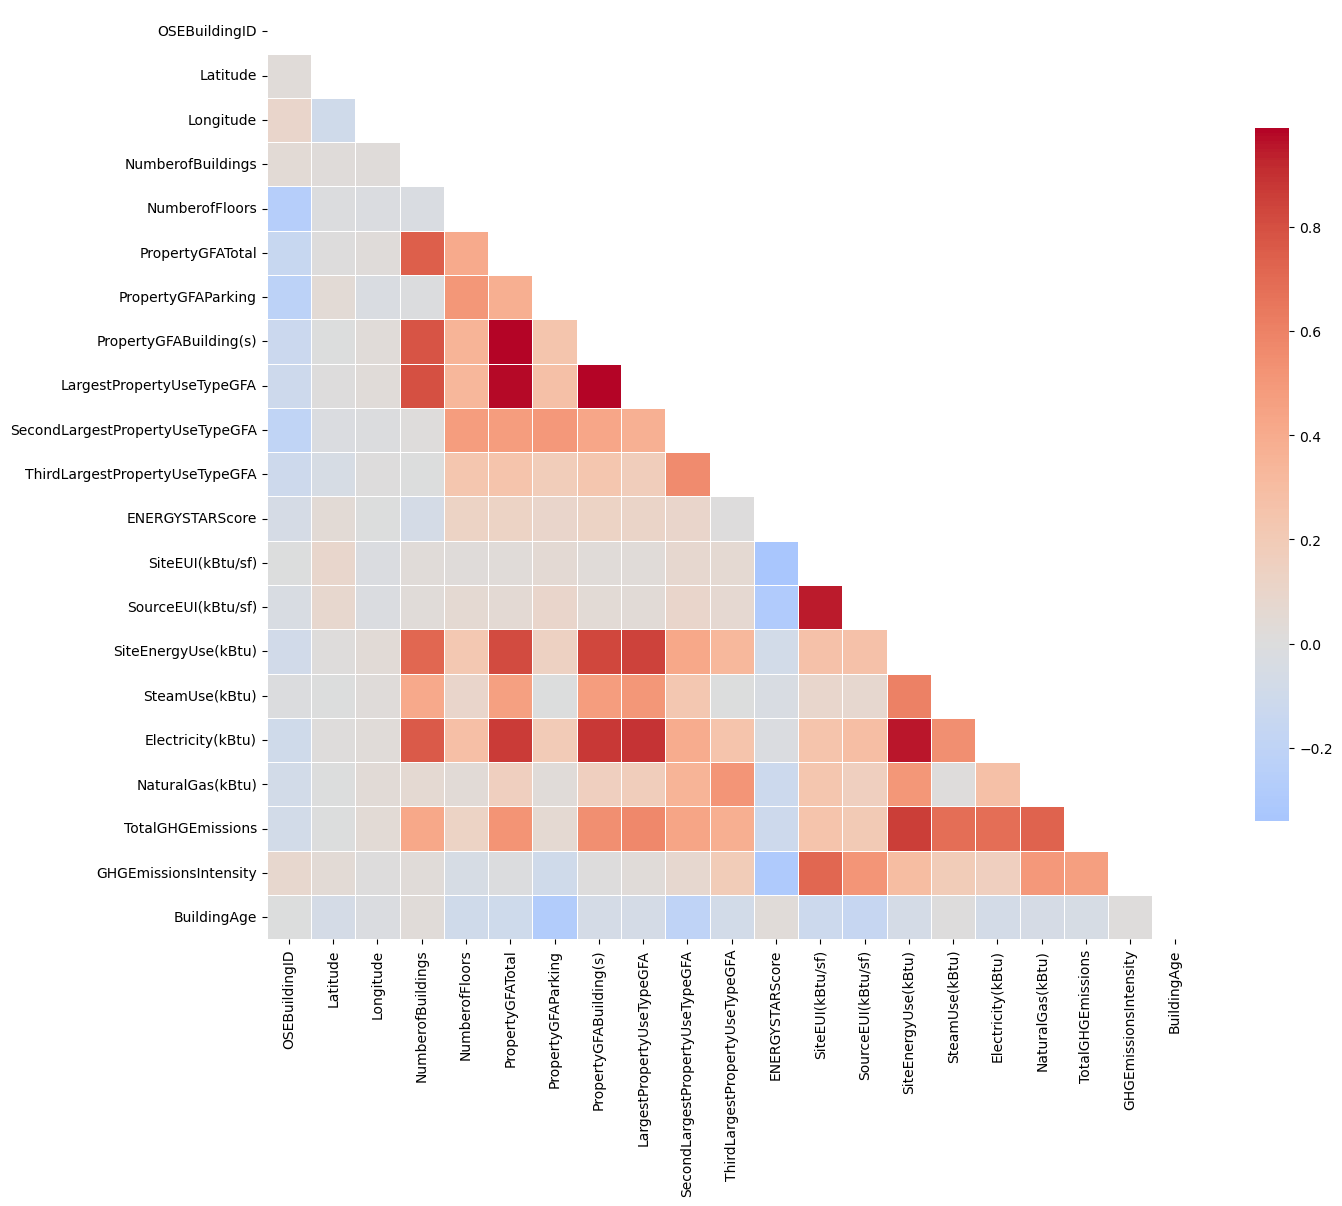

In [578]:
display_corr(data)

### Creation de nouvelles colonnes: Type d'energie la plus utilisé. et pourcentage de la consomation pour chaque energie

In [579]:
# Créer les colonnes avec des 0
data['most_use_steam'] = 0
data['most_use_natural'] = 0
data['most_use_electric'] = 0

# Identifier l'énergie la plus utilisée
data['most_use_steam'] = (data['SteamUse(kBtu)'] > data['Electricity(kBtu)']) & (data['SteamUse(kBtu)'] > data['NaturalGas(kBtu)'])
data['most_use_natural'] = (data['NaturalGas(kBtu)'] > data['Electricity(kBtu)']) & (data['NaturalGas(kBtu)'] > data['SteamUse(kBtu)'])
data['most_use_electric'] = (data['Electricity(kBtu)'] > data['NaturalGas(kBtu)']) & (data['Electricity(kBtu)'] > data['SteamUse(kBtu)'])

# Convertir les colonnes en 0 ou 1
data['use_stream'] = (data['SteamUse(kBtu)'] != 0).astype(int)
data['use_electricity'] = (data['Electricity(kBtu)'] != 0).astype(int)
data['use_natural'] = (data['NaturalGas(kBtu)'] != 0).astype(int)

# Calculer le pourcentage d'utilisation de chaque énergie par ligne
total_energy_per_row = data[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].sum(axis=1)
data['percent_steam'] = data['SteamUse(kBtu)']*100 / total_energy_per_row
data['percent_natural'] = data['NaturalGas(kBtu)']*100 / total_energy_per_row
data['percent_electricity'] = data['Electricity(kBtu)']*100 / total_energy_per_row




most_use_steam: Cette colonne est créée pour identifier si le chauffage à la vapeur est la source d'énergie la plus utilisée pour chaque bâtiment.  
most_use_natural: Cette colonne identifie si le gaz naturel est la source d'énergie la plus utilisée pour chaque bâtiment.  
most_use_electric: Cette colonne indique si l'électricité est la source d'énergie la plus utilisée pour chaque bâtiment.  
  
use_stream, use_electricity, use_natural: Ces colonnes indiquent respectivement si le chauffage à la vapeur, l'électricité ou le gaz naturel est utilisé dans chaque bâtiment. 
  
percent_steam, percent_natural, percent_electricity: Ces colonnes représentent le pourcentage d'utilisation de chaque source d'énergie par rapport à la consommation totale d'énergie pour chaque bâtiment. 

In [580]:
display(data)

OSEBuildingID        BuildingType PrimaryPropertyType  \
0                 1      NonResidential               Hotel   
1                 2      NonResidential               Hotel   
2                 3      NonResidential               Hotel   
3                 5      NonResidential               Hotel   
4                 8      NonResidential               Hotel   
...             ...                 ...                 ...   
3371          50222  Nonresidential COS              Office   
3372          50223  Nonresidential COS               Other   
3373          50224  Nonresidential COS               Other   
3374          50225  Nonresidential COS  Mixed Use Property   
3375          50226  Nonresidential COS  Mixed Use Property   

     TaxParcelIdentificationNumber           Neighborhood  Latitude  \
0                       0659000030               DOWNTOWN  47.61220   
1                       0659000220               DOWNTOWN  47.61317   
2                       0659000475               DOWNTOWN  47.61393   
3                       0659000640               DOWNTOWN  47.61412   
4                       0659000970               DOWNTOWN  47.61375   
...                            ...                    ...       ...   
3371                    1624049080       GREATER DUWAMISH  47.56722   
3372                    3558300000               DOWNTOWN  47.59625   
3373                    1794501150  MAGNOLIA / QUEEN ANNE  47.63644   
3374                    7883603155       GREATER DUWAMISH  47.52832   
3375                    7857002030       GREATER DUWAMISH  47.53939   

      Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0    -122.33799                1.0              12             88434   
1    -122.33393                1.0              11            103566   
2    -122.33810                1.0              41            956110   
3    -122.33664                1.0              10             61320   
4    -122.34047                1.0              18            175580   
...         ...                ...             ...               ...   
3371 -122.31154                1.0               1             12294   
3372 -122.32283                1.0               1             16000   
3373 -122.35784                1.0               1             13157   
3374 -122.32431                1.0               1             14101   
3375 -122.29536                1.0               1             18258   

      PropertyGFAParking  PropertyGFABuilding(s)  \
0                      0                   88434   
1                  15064                   88502   
2                 196718                  759392   
3                      0                   61320   
4                  62000                  113580   
...                  ...                     ...   
3371                   0                   12294   
3372                   0                   16000   
3373                   0                   13157   
3374                   0                   14101   
3375                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
3371                                             Office   
3372                                 Other - Recreation   
3373  Fitness Center/Health Club/Gym, Other - Recrea...   
3374  Fitness Center/Health Club/Gym, Food Service, ...   
3375  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     H

## Feature engineering et analyse exploratoire

In [581]:
data.describe().T

count          mean           std  \
OSEBuildingID                    1633.0  1.637895e+04  1.380246e+04   
Latitude                         1633.0  4.761607e+01  4.818491e-02   
Longitude                        1633.0 -1.223329e+02  2.449862e-02   
NumberofBuildings                1633.0  1.201470e+00  2.951893e+00   
NumberofFloors                   1633.0  4.154317e+00  6.625352e+00   
PropertyGFATotal                 1633.0  1.191986e+05  2.986863e+05   
PropertyGFAParking               1633.0  1.313252e+04  4.267788e+04   
PropertyGFABuilding(s)           1633.0  1.060661e+05  2.853226e+05   
LargestPropertyUseTypeGFA        1629.0  9.891134e+04  2.783417e+05   
SecondLargestPropertyUseTypeGFA  1633.0  1.878339e+04  5.116768e+04   
ThirdLargestPropertyUseTypeGFA   1633.0  3.207649e+03  1.814989e+04   
ENERGYSTARScore                  1082.0  6.515896e+01  2.836984e+01   
SiteEUI(kBtu/sf)                 1633.0  7.311035e+01  7.374346e+01   
SourceEUI(kBtu/sf)               1633.0  1.780755e+02  1.843940e+02   
SiteEnergyUse(kBtu)              1633.0  8.557869e+06  3.051237e+07   
SteamUse(kBtu)                   1633.0  5.229307e+05  5.568926e+06   
Electricity(kBtu)                1633.0  5.911379e+06  2.096914e+07   
NaturalGas(kBtu)                 1633.0  2.000854e+06  9.461064e+06   
TotalGHGEmissions                1633.0  1.878399e+02  7.591613e+02   
GHGEmissionsIntensity            1633.0  1.632554e+00  2.352201e+00   
BuildingAge                      1633.0  5.397122e+01  3.268323e+01   
use_stream                       1633.0  6.981017e-02  2.549049e-01   
use_electricity                  1633.0  9.981629e-01  4.283525e-02   
use_natural                      1633.0  7.213717e-01  4.484615e-01   
percent_steam                    1631.0  2.159579e+00  9.248793e+00   
percent_natural                  1631.0  2.807058e+01  2.639324e+01   
percent_electricity              1631.0  6.976984e+01  2.620567e+01   

                                         min           25%           50%  \
OSEBuildingID                        1.00000  5.860000e+02  2.117200e+04   
Latitude                            47.49917  4.758528e+01  4.761240e+01   
Longitude                         -122.41182 -1.223432e+02 -1.223329e+02   
NumberofBuildings                    1.00000  1.000000e+00  1.000000e+00   
NumberofFloors                       0.00000  1.000000e+00  2.000000e+00   
PropertyGFATotal                 11285.00000  2.940000e+04  4.924300e+04   
PropertyGFAParking                   0.00000  0.000000e+00  0.000000e+00   
PropertyGFABuilding(s)            3636.00000  2.839700e+04  4.721500e+04   
LargestPropertyUseTypeGFA         5656.00000  2.555700e+04  4.361500e+04   
SecondLargestPropertyUseTypeGFA      0.00000  0.000000e+00  0.000000e+00   
ThirdLargestPropertyUseTypeGFA       0.00000  0.000000e+00  0.000000e+00   
ENERGYSTARScore                      1.00000  4.800000e+01  7.300000e+01   
SiteEUI(kBtu/sf)                     0.00000  3.440000e+01  5.220000e+01   
SourceEUI(kBtu/sf)                   0.00000  7.870000e+01  1.324000e+02   
SiteEnergyUse(kBtu)                  0.00000  1.268459e+06  2.619088e+06   
SteamUse(kBtu)                       0.00000  0.000000e+00  0.000000e+00   
Electricity(kBtu)                    0.00000  7.412870e+05  1.640689e+06   
NaturalGas(kBtu)                     0.00000  0.000000e+00  5.161970e+05   
TotalGHGEmissions                    0.00000  2.090000e+01  5.032000e+01   
GHGEmissionsIntensity                0.00000  3.600000e-01  8.900000e-01   
BuildingAge                          1.00000  2.700000e+01  5.000000e+01   
use_stream                           0.00000  0.000000e+00  0.000000e+00   
use_electricity                      0.00000  1.000000e+00  1.000000e+00   
use_natural                          0.00000  0.000000e+00  1.000000e+00   
percent_steam                        0.00000  0.000000e+00  0.000000e+00   
percent_natural                      0.00000  0.000000e+00  2.465617e

Nombre de Bâtiments et Nombre d'Étages :

Le nombre moyen de bâtiments est d'environ 1,2 avec un écart-type de 2,95, ce qui suggère une variation significative.
Le nombre moyen d'étages est d'environ 4,15 avec une variation relativement plus faible (écart-type de 6,63).

Surface Totale et Surface de Parking :

Les valeurs moyennes et médianes pour la surface totale du bâtiment et la surface de stationnement sont beaucoup plus élevées que les valeurs minimales, ce qui suggère une grande variabilité dans la taille des bâtiments.

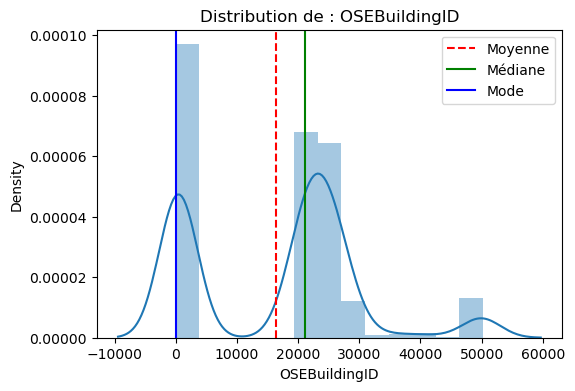

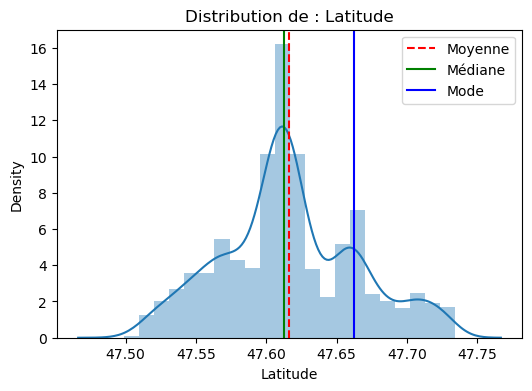

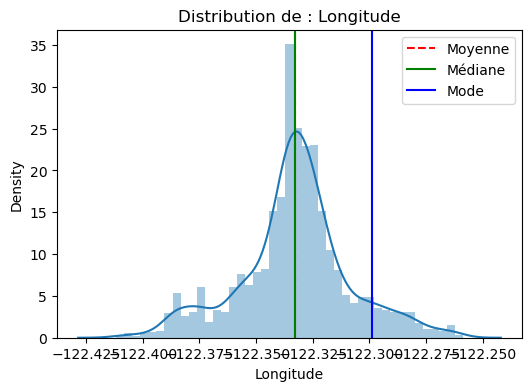

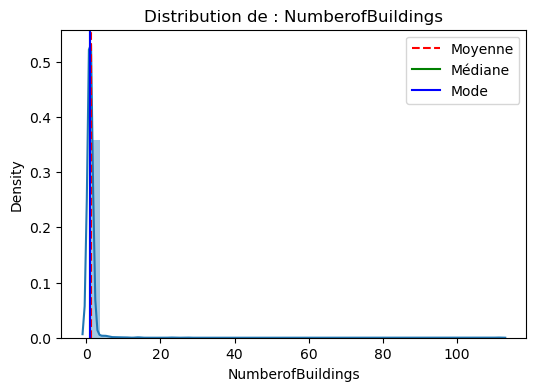

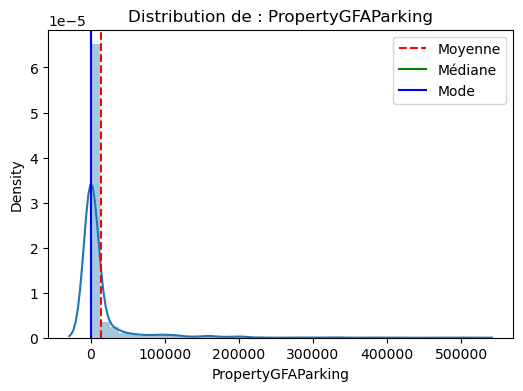

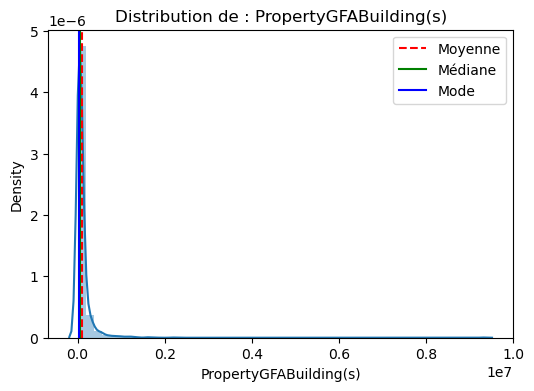

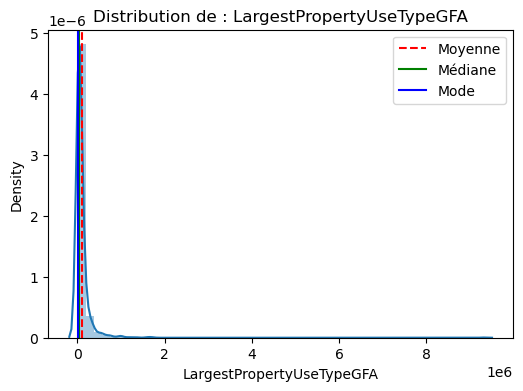

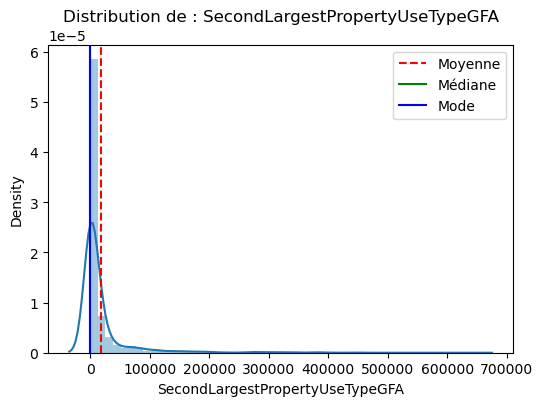

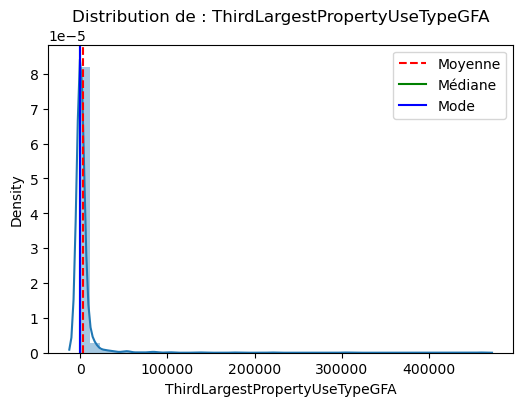

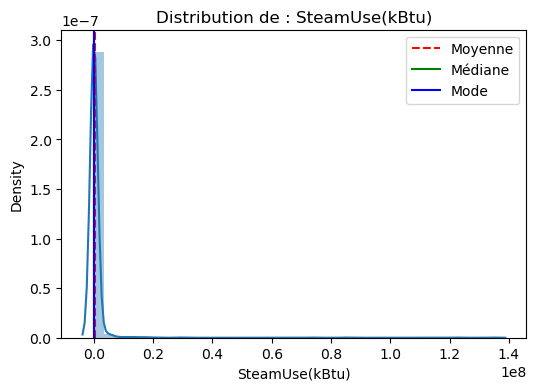

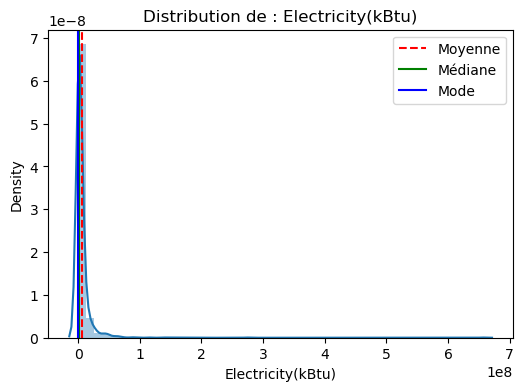

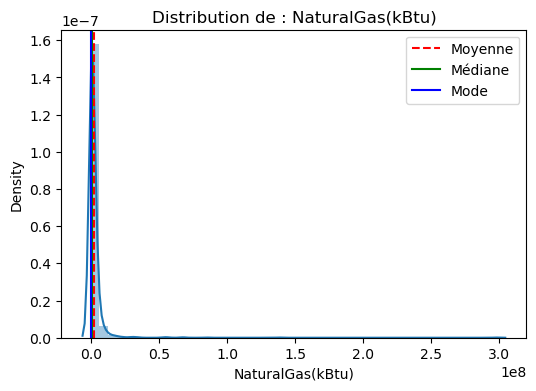

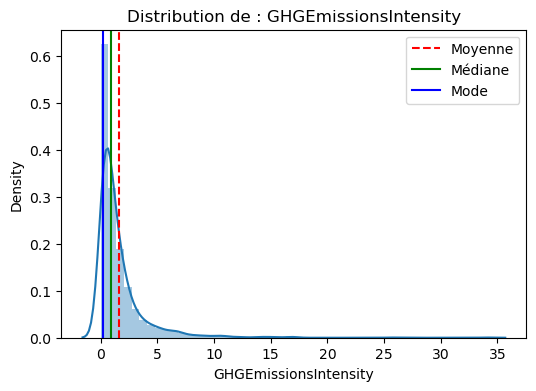

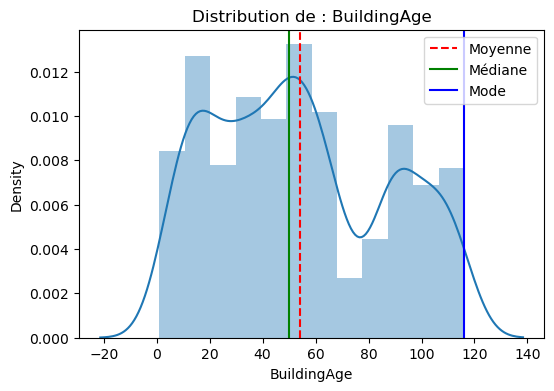

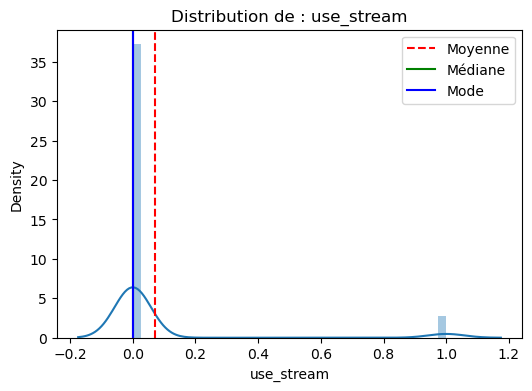

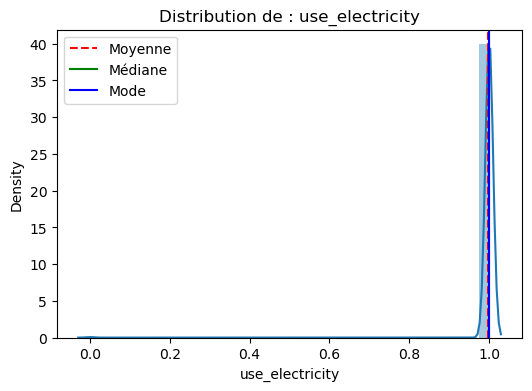

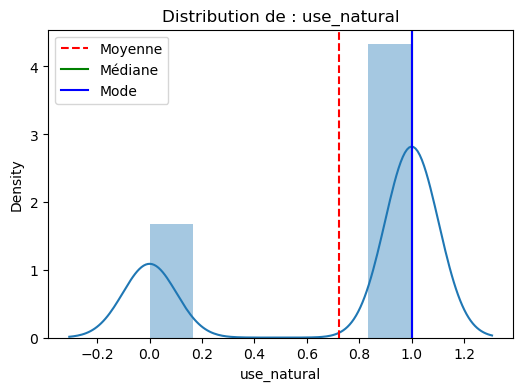

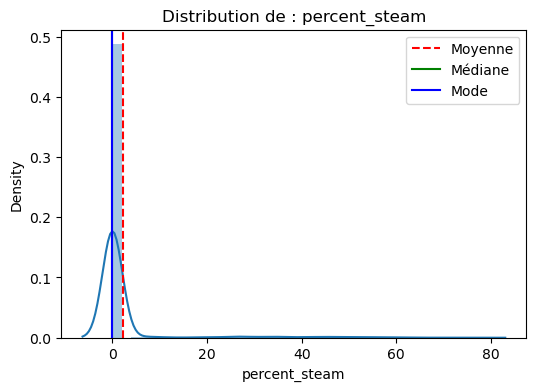

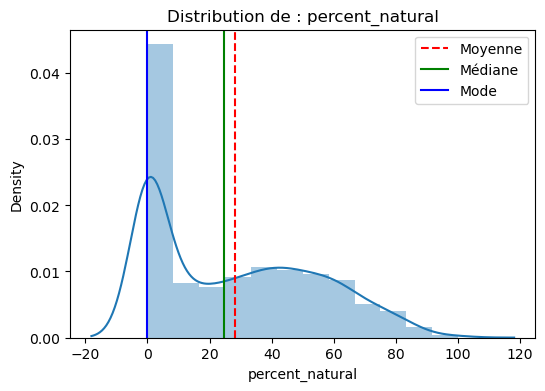

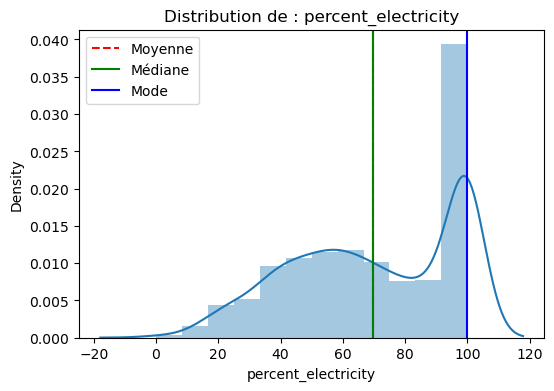

In [582]:
for col in data.select_dtypes("number"):
    plt.figure(figsize = (6,4))
    sns.distplot(data[col])
    plt.axvline(data[col].mean(), color='r', linestyle='--', label="Moyenne")
    plt.axvline(data[col].median(), color='g', linestyle='-', label="Médiane")
    plt.axvline(data[col].mode().values[0], color='b', linestyle='-', label="Mode")
    chaine = 'Distribution de : ' + col
    plt.title(chaine)
    plt.legend()
    plt.show()

In [583]:
def descriptives_stat(dataframe, liste_variables):

    liste_mean = ['moyenne']
    liste_median = ['médiane']
    liste_var = ['variance']
    liste_std = ['écart-type']
    liste_skew = ["skewness : mesure d'asymétrie"]
    liste_kurtosis = ["kurtosis: mesure d'aplatissement"]
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['max']
    liste_min = ['min']
    liste_count = ['count']

    for col in liste_variables:
        liste_mean.append(dataframe[col].mean())
        liste_median.append(dataframe[col].median())
        liste_var.append(dataframe[col].var(ddof=1))  # Utilisation de ddof=1 pour l'échantillon
        liste_std.append(dataframe[col].std(ddof=1))  # Utilisation de ddof=1 pour l'échantillon
        liste_skew.append(dataframe[col].skew())
        liste_kurtosis.append(dataframe[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(dataframe[col].mode().tolist())  # Stocker la série complète des modes
        liste_min.append(dataframe[col].min())
        liste_max.append(dataframe[col].max())
        liste_count.append(dataframe[col].count())

    data_stats = [liste_count, liste_mean, liste_std, liste_median, liste_min, liste_var,  liste_skew,
                  liste_kurtosis, liste_mode, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)
    
    return df_stat


In [584]:
descriptives_stat(data,data.select_dtypes("number").columns)

Desc  \
0                             count   
1                           moyenne   
2                        écart-type   
3                           médiane   
4                               min   
5                          variance   
6     skewness : mesure d'asymétrie   
7  kurtosis: mesure d'aplatissement   
8                              mode   
9                               max   

                                       OSEBuildingID    Latitude  \
0                                               1633        1633   
1                                       16378.946724   47.616073   
2                                       13802.461636    0.048185   
3                                            21172.0     47.6124   
4                                                  1    47.49917   
5                                   190507947.209783    0.002322   
6                                           0.314195    0.227578   
7                                          -0.394765   -0.234626   
8  [1, 2, 3, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18,...  [47.66246]   
9                                              50226    47.73387   

      Longitude NumberofBuildings NumberofFloors       PropertyGFATotal  \
0          1633              1633           1633                   1633   
1   -122.332881           1.20147       4.154317           119198.57624   
2      0.024499          2.951893       6.625352          298686.298332   
3    -122.33289               1.0            2.0                49243.0   
4    -122.41182               1.0              0                  11285   
5        0.0006          8.713674      43.895289     89213504811.504181   
6     -0.066012         32.421367       5.988074              19.256009   
7      0.762003       1180.301356      51.727429             556.950516   
8  [-122.29898]             [1.0]            [1]  [25920, 28800, 36000]   
9    -122.25864             111.0             99                9320156   

  PropertyGFAParking PropertyGFABuilding(s) LargestPropertyUseTypeGFA  \
0               1633                   1633                      1629   
1       13132.522352          106066.053889              98911.341314   
2       42677.881614          285322.594261             278341.671983   
3                0.0                47215.0                   43615.0   
4                  0                   3636                    5656.0   
5  1821401579.017954     81408982795.618484        77474086362.476776   
6           5.169402              21.802032                 23.309902   
7          34.748666              671.24572                743.720306   
8                [0]  [25920, 28800, 36000]        [24000.0, 30000.0]   
9             512608                9320156                 9320156.0   

  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseTypeGFA  \
0                            1633                           1633   
1                      18783.3872                    3207.648744   
2                    51167.678584                   18149.893524   
3                             0.0                            0.0   
4                             0.0                            0.0   
5               2618131331.697302               329418634.937762   
6                        5.177142                      15.358146   
7                       34.697716                     314.034035   
8                           [0.0]                          [0.0]   
9                        639931.0                       459748.0   

  ENERGYSTARScore                  SiteEUI(kBtu/sf)  \
0            1082                              1633   
1       65.158965                         73.110349   
2       28.369843                         73.743455   
3            73.0                         52.200001   
4             1.0                               0.0   
5      804.847972                       5438.097183   
6       -0.770817                          3.784511   
7       -0.513719                

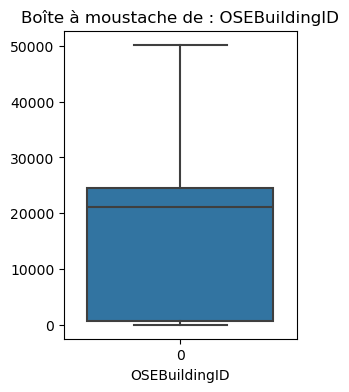

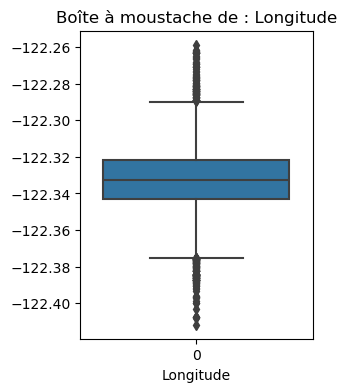

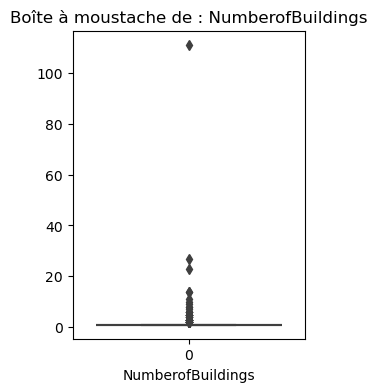

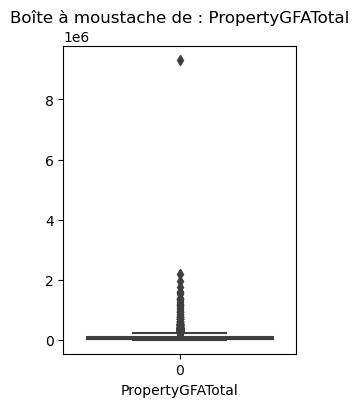

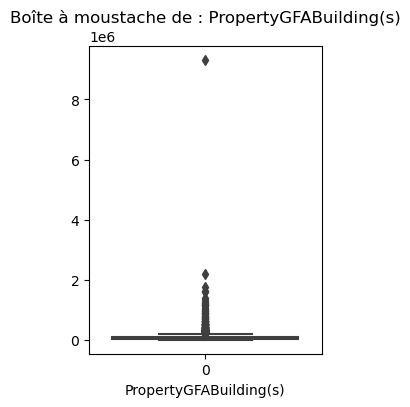

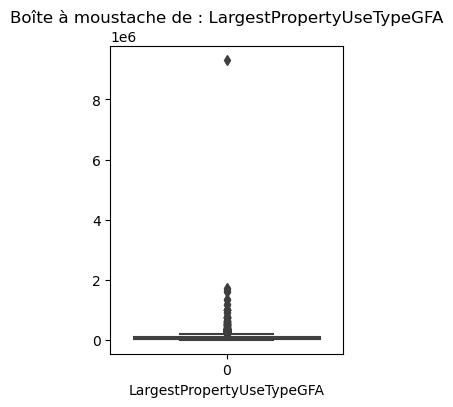

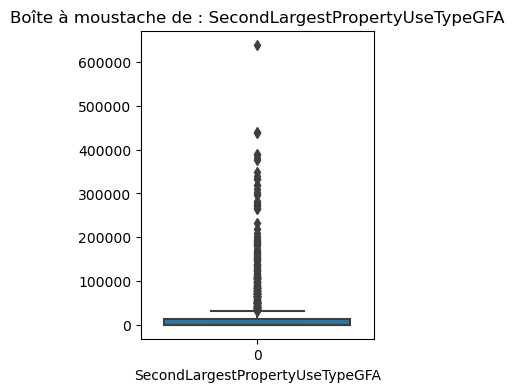

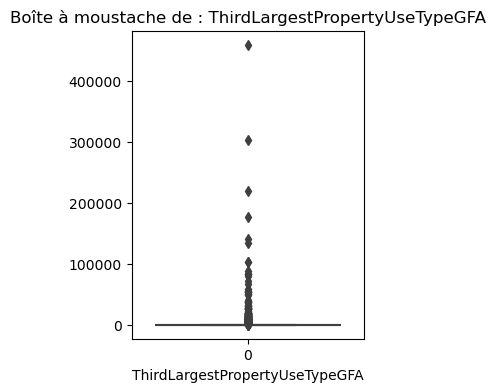

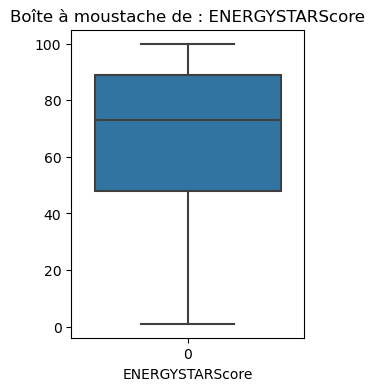

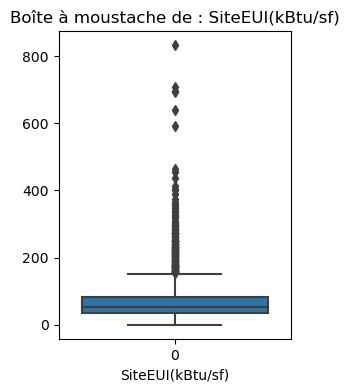

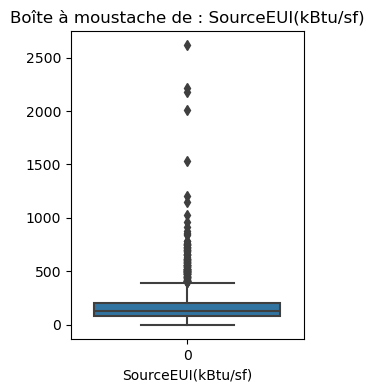

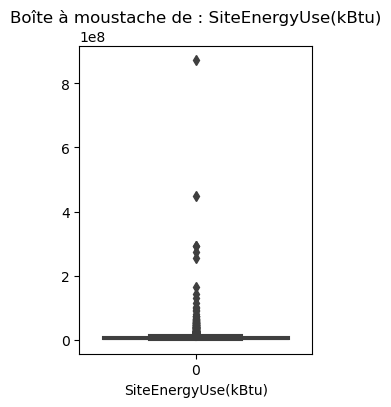

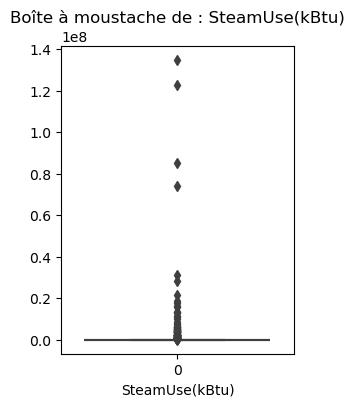

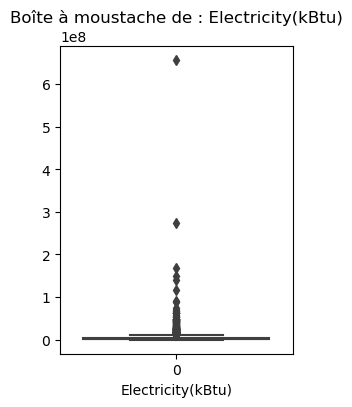

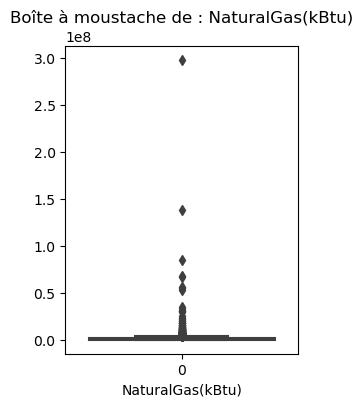

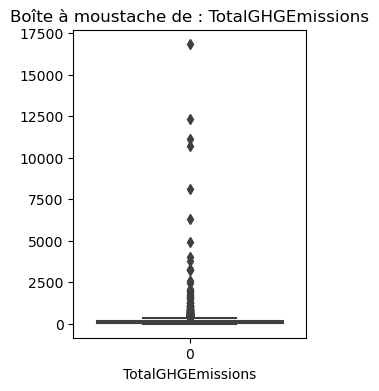

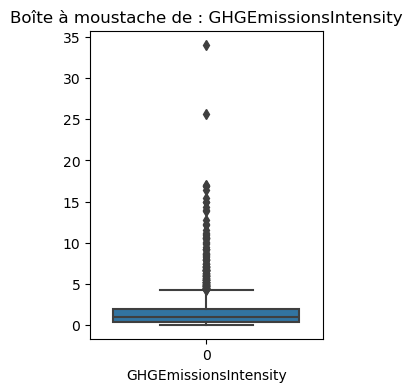

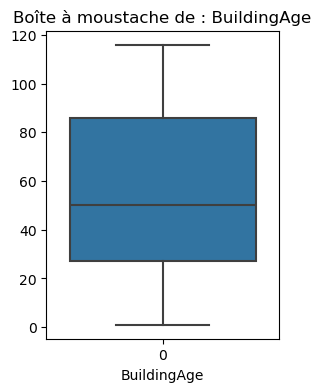

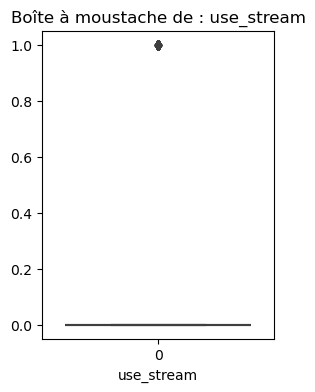

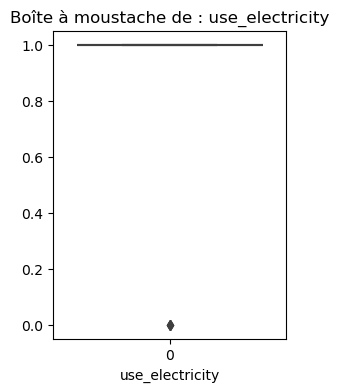

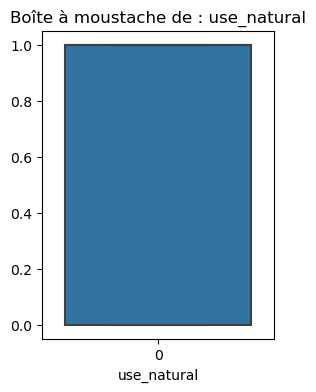

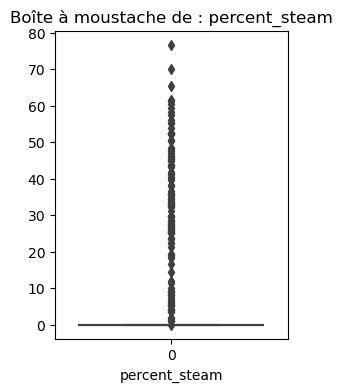

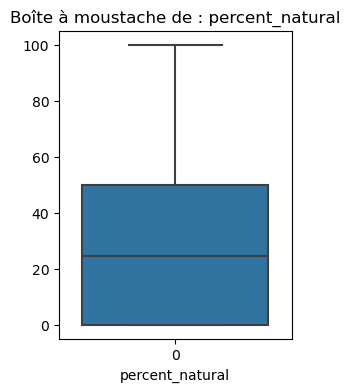

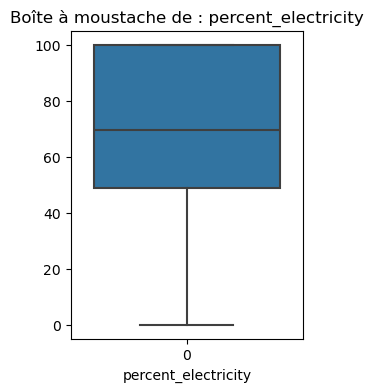

In [585]:
for col in data.select_dtypes("number"):
    plt.figure(figsize = (3,4))
    sns.boxplot(data[col])
    chaine = 'Boîte à moustache de : ' + col
    plt.xlabel(col)
    plt.title(chaine)
    plt.show()


In [586]:
categorical = data.select_dtypes("object").columns.tolist()
categorical.remove('ListOfAllPropertyUseTypes')

for cols in categorical: 
    fig = px.histogram(data, x=cols, color = cols, color_discrete_sequence=px.colors.qualitative.Dark2)
    chaine = 'Distribution de : ' + cols
    fig.update_layout(title= chaine, height=500, width=700)
    fig.show()

In [587]:
def display_corr(data):
    numeric_data = data.select_dtypes(include='number')

    corr = numeric_data.corr()
# On affiche que le triangle du bas
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(17, 20))


# Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="coolwarm",annot= True, fmt = ".2f", center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})

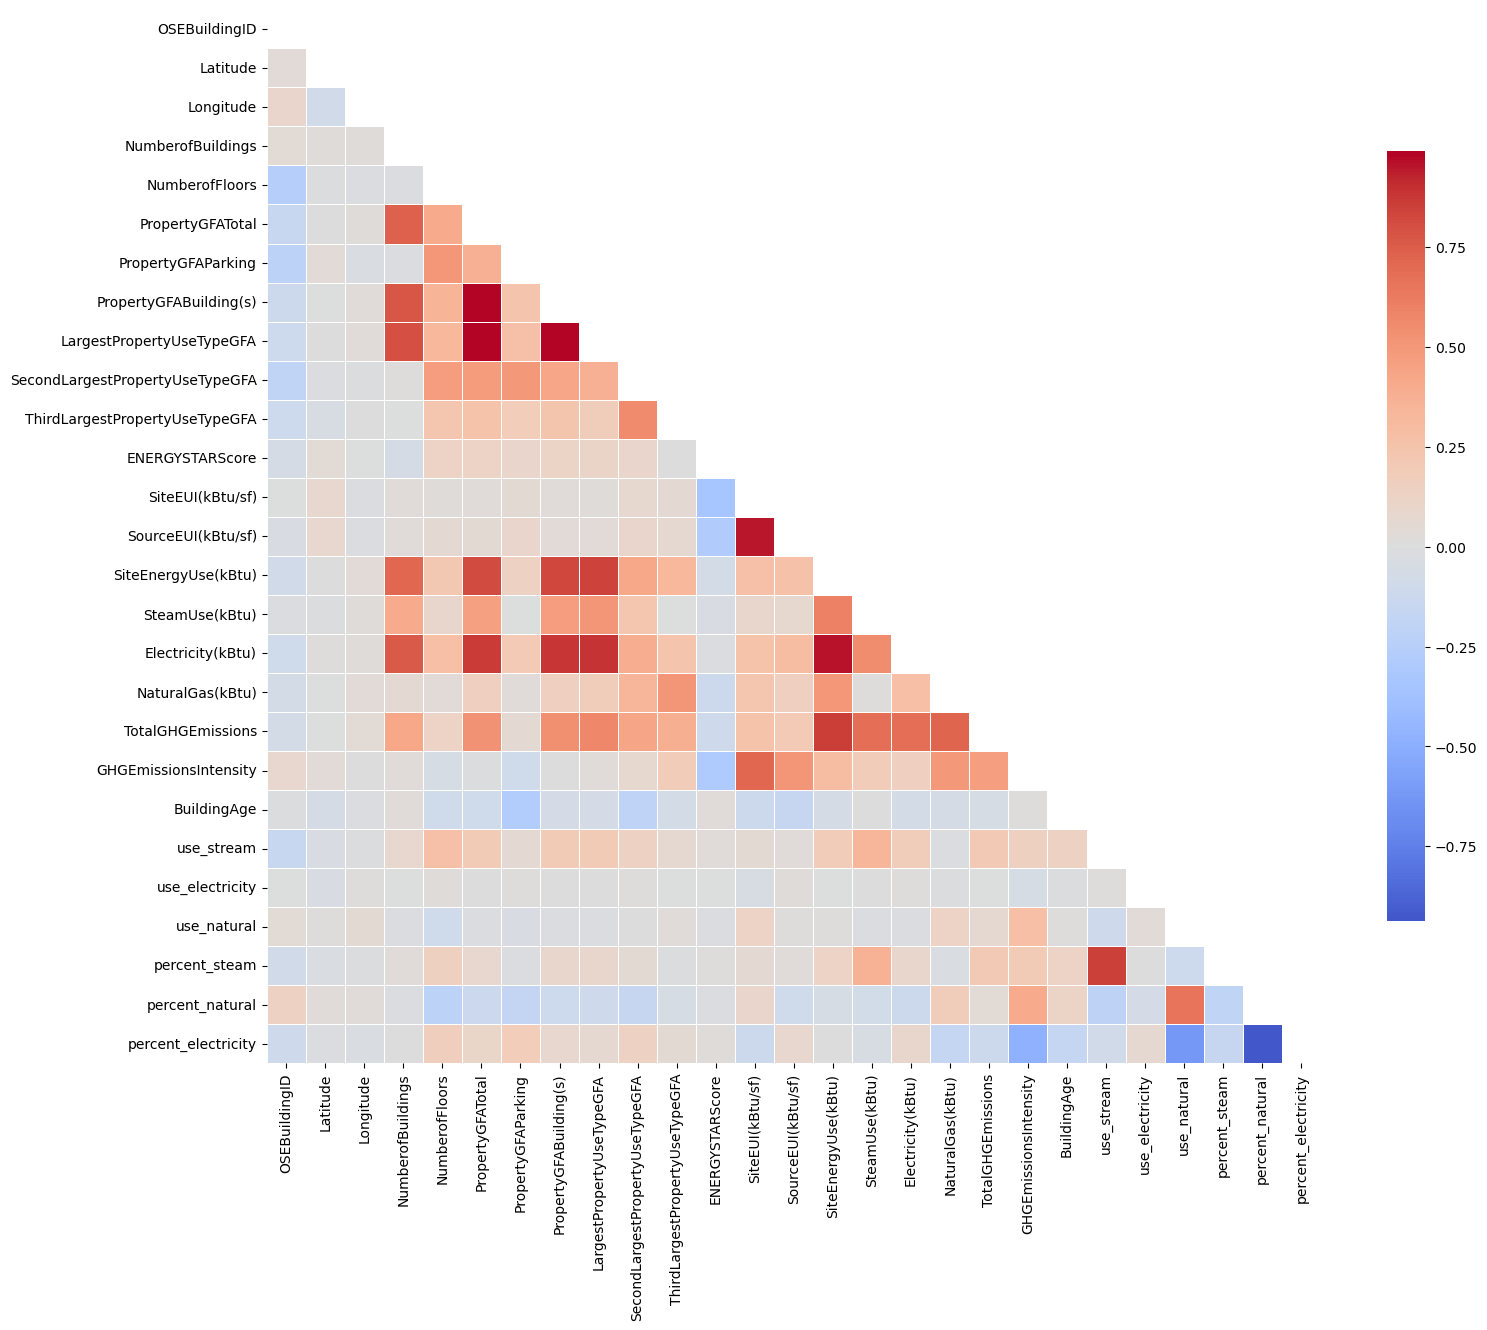

In [588]:
display_corr(data)

Forte corrélation entre les variables property et EnergyUse

In [589]:
surface_variables = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',"PropertyGFABuilding(s)",
                     "PropertyGFAParking"]

# Calcul des pourcentages par rapport à la surface totale
for var in surface_variables:
    new_var_name = f'{var}_rate'
    data[new_var_name] = round((data[var] / data['PropertyGFATotal']) * 100, 2)

# Supprimer les anciennes variables de surface
data = data.drop(surface_variables, axis=1)



In [590]:
data['GFAPerBuilding'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),3)
data['GFAPerFloor'] = round((data['PropertyGFATotal'] / data['NumberofFloors']),3)

In [591]:
data["NumberOfAllUseTypes"]= data.ListOfAllPropertyUseTypes.apply(lambda row: len(row))
data.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

  TaxParcelIdentificationNumber Neighborhood  Latitude  Longitude  \
0                    0659000030     DOWNTOWN  47.61220 -122.33799   
1                    0659000220     DOWNTOWN  47.61317 -122.33393   
2                    0659000475     DOWNTOWN  47.61393 -122.33810   
3                    0659000640     DOWNTOWN  47.61412 -122.33664   
4                    0659000970     DOWNTOWN  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0                1.0              12             88434   
1                1.0              11            103566   
2                1.0              41            956110   
3                1.0              10             61320   
4                1.0              18            175580   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2                          Hotel                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType  ENERGYSTARScore  \
0               no information              no information             60.0   
1                      Parking                  Restaurant             61.0   
2               no information              no information             43.0   
3               no information              no information             56.0   
4                      Parking               Swimming Pool             75.0   

   SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
0         81.699997          182.500000            7226362.5      2003882.00   
1         94.800003          176.100006            8387933.0            0.00   
2         96.000000          241.899994           72587024.0     21566554.00   
3        110.800003          216.199997            6794584.0      2214446.25   
4        114.800003          211.399994           14172606.0            0.00   

   Electricity(kBtu)  NaturalGas(kBtu) ComplianceStatus  TotalGHGEmissions  \
0          3946027.0         1276453.0        Compliant             249.98   
1          3242851.0         5145082.0        Compliant             295.86   
2         49526664.0         1493800.0        Compliant            2089.28   
3          2768924.0         1811213.0        Compliant             286.43   
4          5368607.0         8803998.0        Compliant             505.01   

   GHGEmissionsIntensity  BuildingAge  most_use_steam  most_use_natural  \
0                   2.83           89           False             False   
1                   2.86           20           False              True   
2                   2.19           47           False             False   
3                   4.67           90           False             False   
4                   2.88           36           False              True   

   most_use_electric  use_stream  use_electricity  use_natural  percent_steam  \
0               True           1                1            1      27.730164   
1              False           0                1            1       0.000000   
2               True           1                1            1      29.711310   
3               True           1                1            1      32.591348   
4              False           0                1            1       0.000000   

   percent_natural  percent_electricity  LargestPropertyUseTypeGFA_rate  \
0        17.663840            54.605997                          100.00   
1        61.339093            38.6

In [592]:
def binarise_columns(data, col):
    idx = np.where(data[col] > 0)
    data[col].iloc[idx] = 1
    
    idx_0 = np.where(data[col] == 0)
    data[col].iloc[idx_0] = 0
    return data

In [593]:
for cols in ["most_use_steam","most_use_natural", "most_use_electric"] :
    data = binarise_columns(data,cols)

In [594]:
data = data.drop(labels=["SiteEUI(kBtu/sf)"], axis=1)

#data = data.drop(labels=["PropertyGFATotal"], axis=1)

SiteEUI(kBtu/sf)  is a property's Site Energy Use divided by its gross floor area.
on peut la supprimer et ce servir de SiteEnergyUse(kBtu)

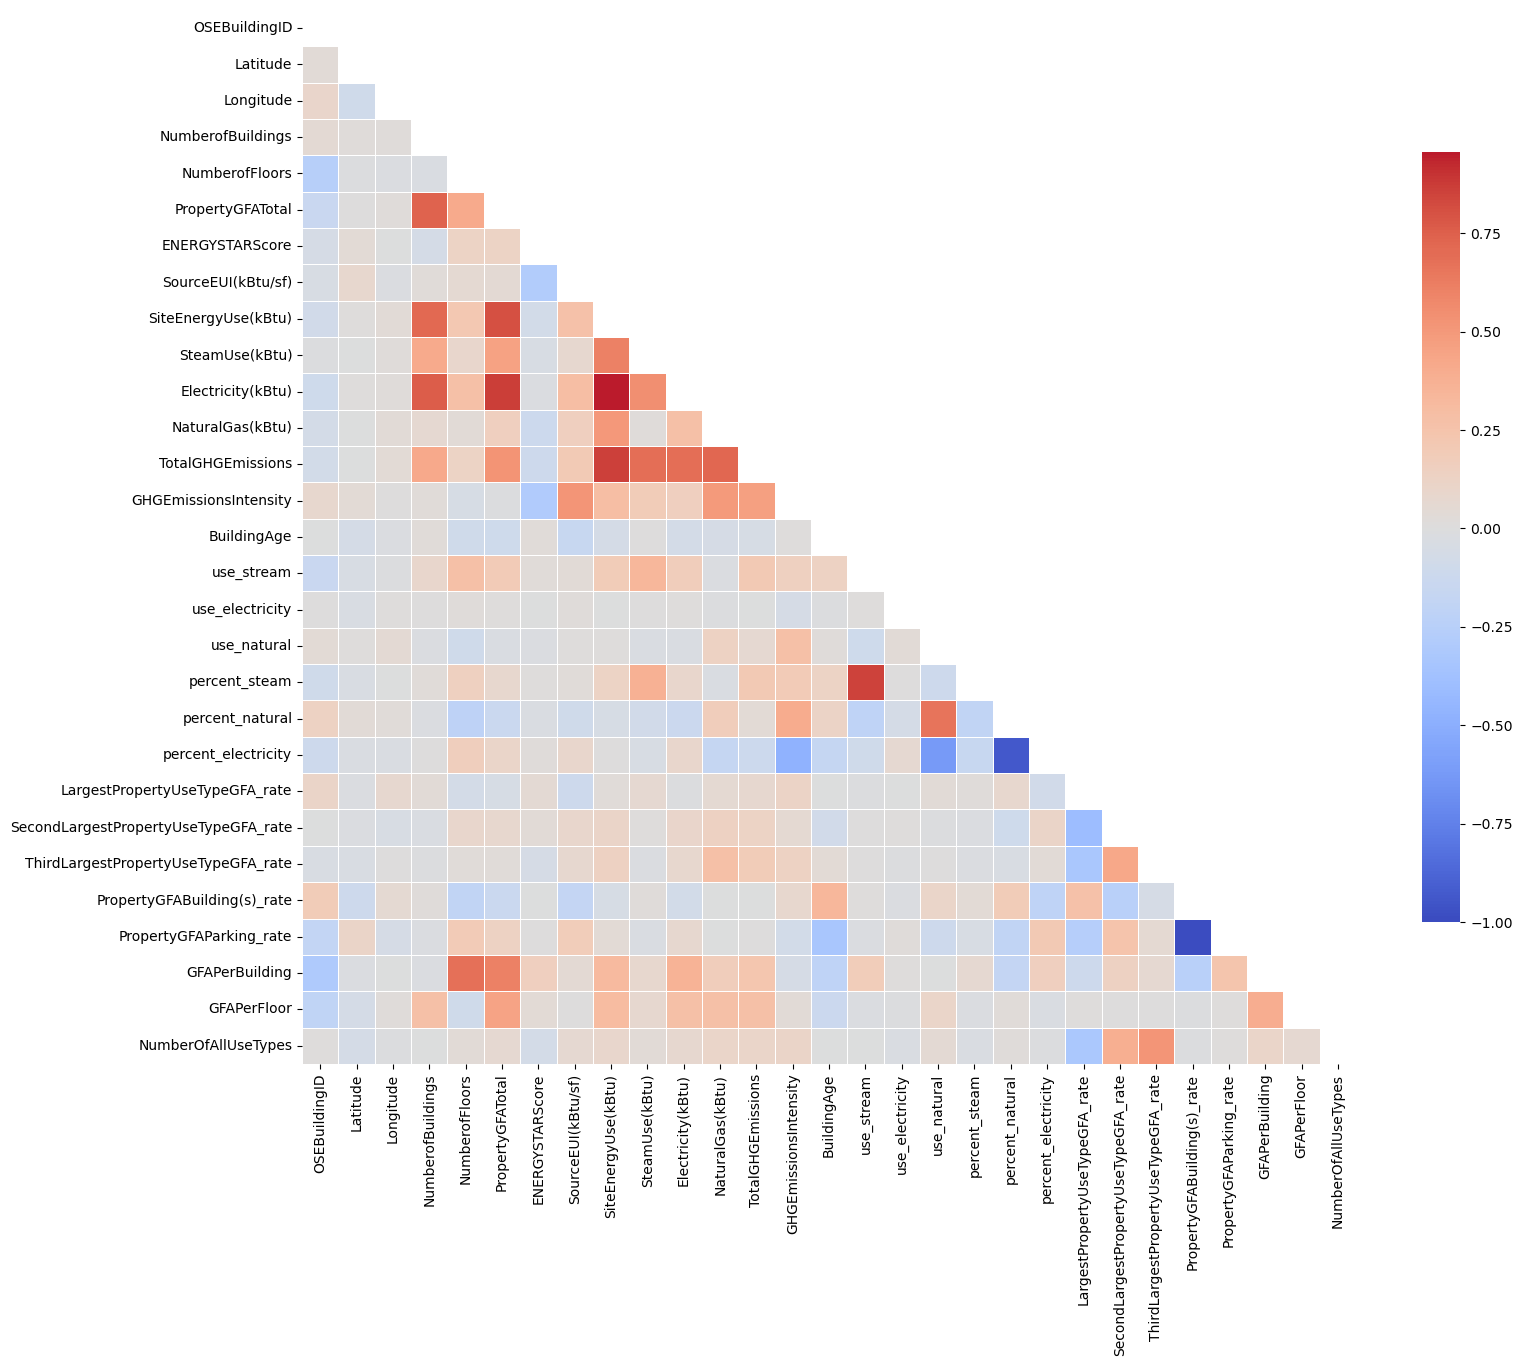

In [595]:
display_corr(data)

## Analyse des Targets

In [596]:
descriptives_stat(data,["TotalGHGEmissions","SiteEnergyUse(kBtu)"])

Desc TotalGHGEmissions  \
0                             count              1633   
1                           moyenne        187.839927   
2                        écart-type        759.161262   
3                           médiane             50.32   
4                               min               0.0   
5                          variance     576325.822423   
6     skewness : mesure d'asymétrie         14.082615   
7  kurtosis: mesure d'aplatissement        242.439822   
8                              mode             [6.3]   
9                               max          16870.98   

                                 SiteEnergyUse(kBtu)  
0                                               1633  
1                                     8557868.763784  
2                                    30512365.009266  
3                                          2619088.5  
4                                                0.0  
5                                 931004418458695.25  
6                                           17.91899  
7                                         438.046052  
8  [0.0, 57133.19922, 79711.79688, 90558.70313, 9...  
9                                        873923712.0


1. ### TotalGHGEmissions :
   - La moyenne (187.84) est significativement plus élevée que la médiane (50.32), indiquant une distribution fortement asymétrique.
   - La valeur de skewness est positive (14.08), ce qui confirme une forte asymétrie à droite.
   - La kurtosis est également élevée (242.44), suggérant une distribution très leptokurtique, c'est-à-dire une distribution avec des queues de distribution plus épaisses que celles d'une distribution normale.
   - La présence de valeurs élevées contribue à l'aplatissement extrême de la distribution.

2. ### SiteEnergyUse(kBtu) :
   - La moyenne (8,557,868.76) et l'écart-type (30,512,365.01) sont considérablement plus élevés que la médiane (2,619,088.5), indiquant une forte asymétrie positive.
   - La skewness (17.92) est très positive, confirmant une distribution fortement asymétrique à droite.
   - La kurtosis (438.05) est extrêmement élevée, suggérant une distribution très leptokurtique avec des queues de distribution très épaisses.

### Conclusion : Les distributions de ces deux variables présentent des caractéristiques d'une distribution très asymétrique à droite (positivement asymétrique) avec une forte concentration de valeurs près de zéro et quelques valeurs extrêmement élevées. Ces distributions pourraient être mieux modélisées en utilisant des techniques adaptées aux distributions asymétriques, comme les transformations logarithmiques ou l'utilisation de modèles spécifiques aux distributions, tels que les modèles de régression Gamma ou log-normale.

In [597]:

from scipy.stats import normaltest

for x in ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]:
    k2, p = normaltest(data[x])
    print(f"Test de normalité de {x}, p = {p}")
    print("-" * 70)
    alpha = 1e-3
    if p < alpha:  # hypothèse nulle: x n'est pas une distribution normale
        print(f"L'hypothèse nulle sur {x} peut être rejetée (la distribution n'est pas normale)")
        print("-" * 70)
    else:
        print(f"L'hypothèse nulle sur {x} ne peut pas être rejetée (la distribution est normale)")
        print("-" * 70)


Test de normalité de TotalGHGEmissions, p = 0.0
----------------------------------------------------------------------
L'hypothèse nulle sur TotalGHGEmissions peut être rejetée (la distribution n'est pas normale)
----------------------------------------------------------------------
Test de normalité de SiteEnergyUse(kBtu), p = 0.0
----------------------------------------------------------------------
L'hypothèse nulle sur SiteEnergyUse(kBtu) peut être rejetée (la distribution n'est pas normale)
----------------------------------------------------------------------


### Distribution TotalGHGEEmission (emission de CO2)

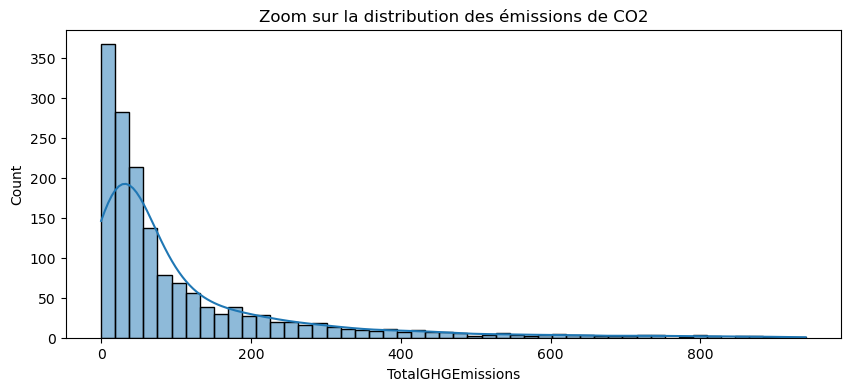

In [598]:
plt.figure(figsize = (10,4))
sns.histplot(data=data[(data['TotalGHGEmissions']< 1000)], x="TotalGHGEmissions", kde=True)
plt.title("Zoom sur la distribution des émissions de CO2")
plt.show()

In [599]:


import plotly.figure_factory as ff
test1 = np.log1p(data['TotalGHGEmissions'])
test2 = np.log2(1+data['TotalGHGEmissions'])
test10 = np.log10(1+data['TotalGHGEmissions'])

#test_log = pd.DataFrame( {'test1': test1, 'test2': test2, 'test10': test10})
print("Variance avec log1p : ",test1.var())
print("Variance avec log2p :", test2.var())
print("Variance avec log10p :", test10.var())



Variance avec log1p :  2.059427104306343
Variance avec log2p : 4.286427693545427
Variance avec log10p : 0.38843204101493384


On choisi la transformation qui donne la plus faible variance donc log10 + 1.

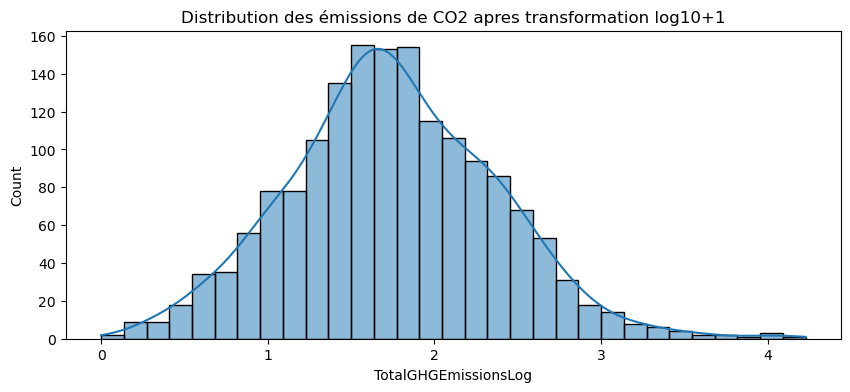

In [600]:
data["TotalGHGEmissionsLog"]= np.log10(1+data["TotalGHGEmissions"])
plt.figure(figsize = (10,4))
sns.histplot(data=data, x="TotalGHGEmissionsLog", kde=True)
plt.title("Distribution des émissions de CO2 apres transformation log10+1")
plt.show()

### Distribution SiteEnergyUse(kBtu) (emission total d'energie)

In [601]:
plt.figure(figsize = (12,6))
sns.histplot(data= data[data["SiteEnergyUse(kBtu)"]<0.4*10**8 ], x = "SiteEnergyUse(kBtu)", kde=True )
plt.title("Zoom sur la distribution de la consommation totale en énergie")
plt.show()

In [602]:
SEUtest1 = np.log1p(data['SiteEnergyUse(kBtu)'])
SEUtest2 = np.log2(1 + data['SiteEnergyUse(kBtu)'])
SEUtest10 = np.log10(1 + data['SiteEnergyUse(kBtu)'])
print("Variance avec log1p : ",SEUtest1.var())
print("Variance avec log2p :", SEUtest2.var())
print("Variance avec log10p :", SEUtest10.var())

Variance avec log1p :  1.7985842615404686
Variance avec log2p : 3.7435174916952145
Variance avec log10p : 0.33923402978752976


On choisi la transformation qui donne la plus faible variance donc log10 + 1.

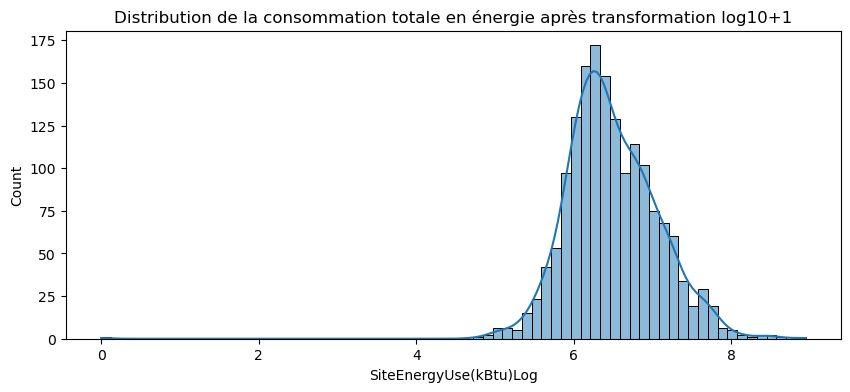

In [603]:
data["SiteEnergyUse(kBtu)Log"]= np.log10(1+data["SiteEnergyUse(kBtu)"])
plt.figure(figsize = (10,4))
sns.histplot(data=data, x="SiteEnergyUse(kBtu)Log", kde=True)
plt.title("Distribution de la consommation totale en énergie après transformation log10+1")
plt.show()

In [604]:
fig = px.scatter(data,
                 x="TotalGHGEmissionsLog",
                 y="SiteEnergyUse(kBtu)Log",
                 title = "Répartition des émissions de CO2 en fonction de la consommation totale en énergie",
                 color = "SiteEnergyUse(kBtu)Log",
                color_continuous_scale=px.colors.sequential.Viridis)
fig.show()
fig = px.scatter(data,
                 y="TotalGHGEmissionsLog",
                 x="SiteEnergyUse(kBtu)Log",
                 title = "Répartition de la consommation totale en énergie en fonction des émissions de CO2",
                 color = "SiteEnergyUse(kBtu)Log",
                color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

Le scatter plot montre une corrélation positive entre la consommation d'énergie et les émissions de CO2. Plus la consommation d'énergie est élevée, plus les émissions de CO2 le sont également. 

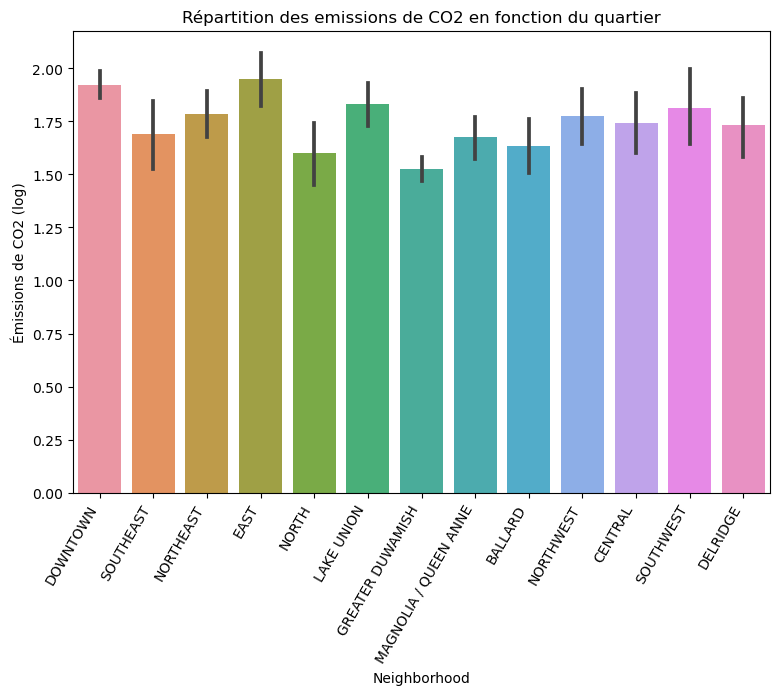

In [605]:

plt.figure(figsize=(9,6))

ax = sns.barplot(x = "Neighborhood", y= "TotalGHGEmissionsLog", data=data)
ax.set(xlabel="Neighborhood", ylabel="Émissions de CO2 (log)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.title("Répartition des emissions de CO2 en fonction du quartier", fontsize=12)
plt.show()

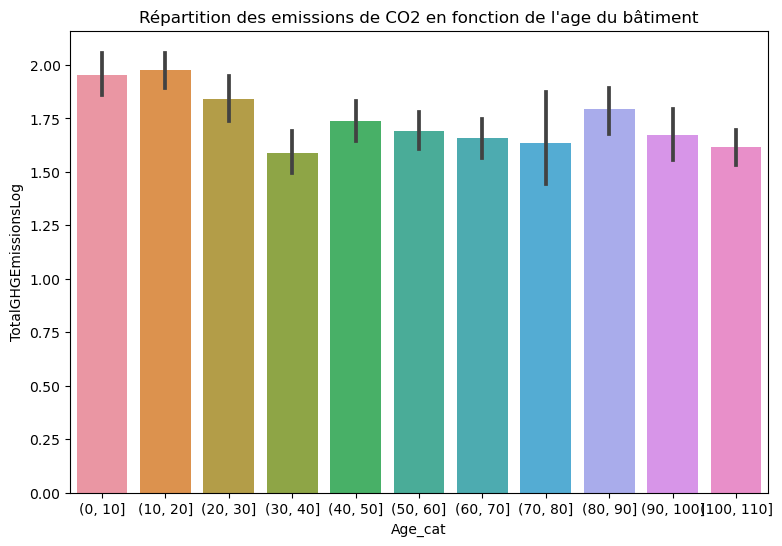

In [606]:
data['Age_cat'] = pd.cut(data['BuildingAge'], 
    bins=[x for x in range(0,120, 10)], 
    right=True)
plt.figure(figsize=(9,6))
sns.barplot(x = "Age_cat", y= "TotalGHGEmissionsLog", data=data)
plt.title("Répartition des emissions de CO2 en fonction de l'age du bâtiment", fontsize=12)
plt.show()

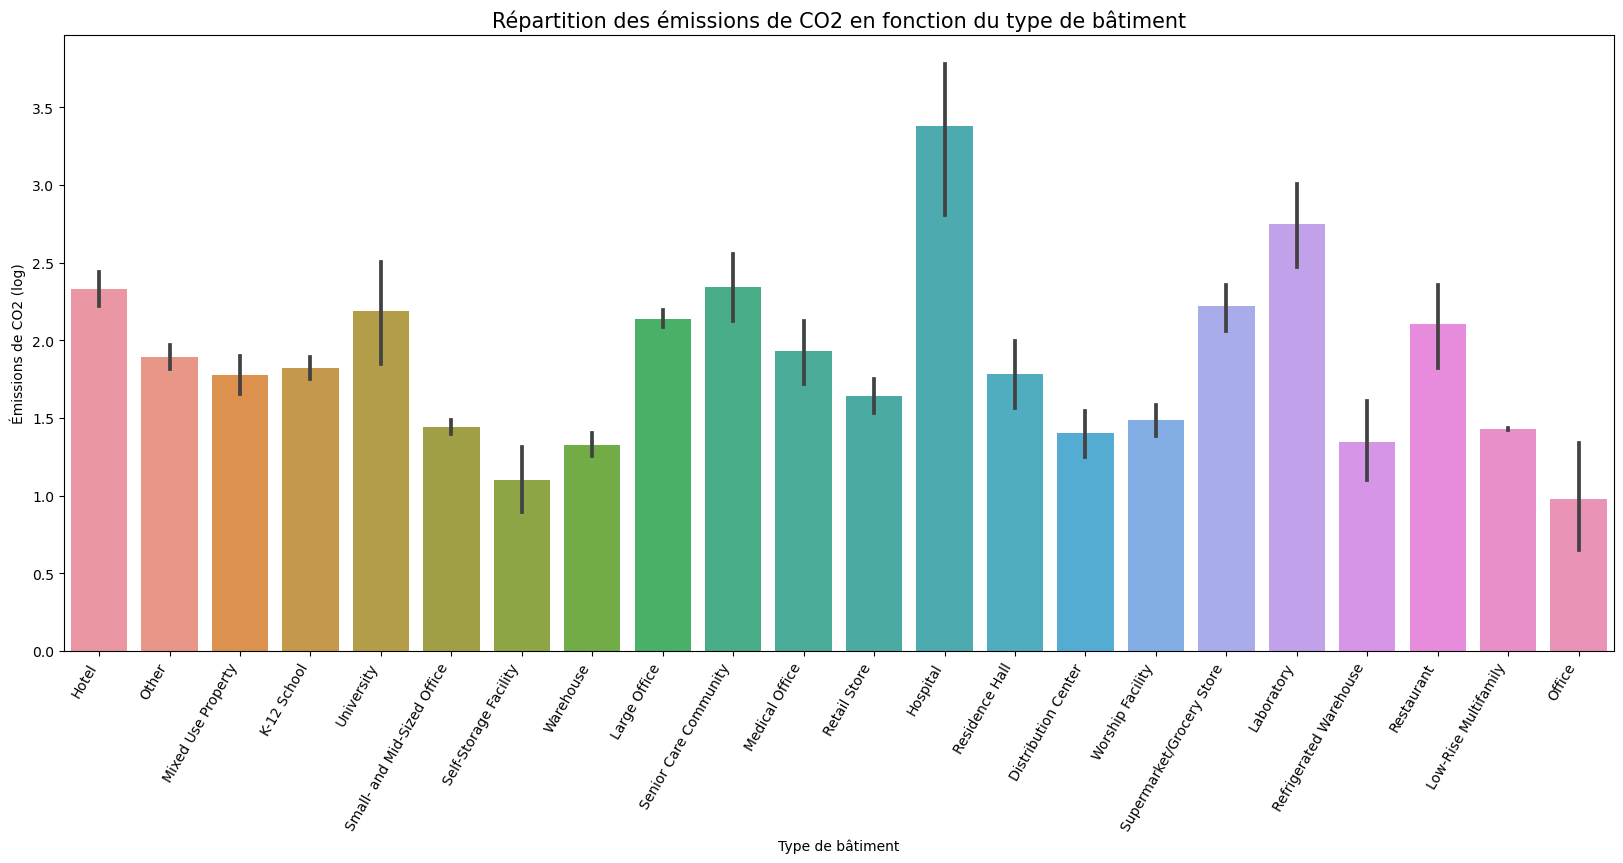

In [607]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(x="PrimaryPropertyType", y="TotalGHGEmissionsLog", data=data)

# Orienter les légendes
ax.set(xlabel="Type de bâtiment", ylabel="Émissions de CO2 (log)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.title("Répartition des émissions de CO2 en fonction du type de bâtiment", fontsize=15)
plt.show()

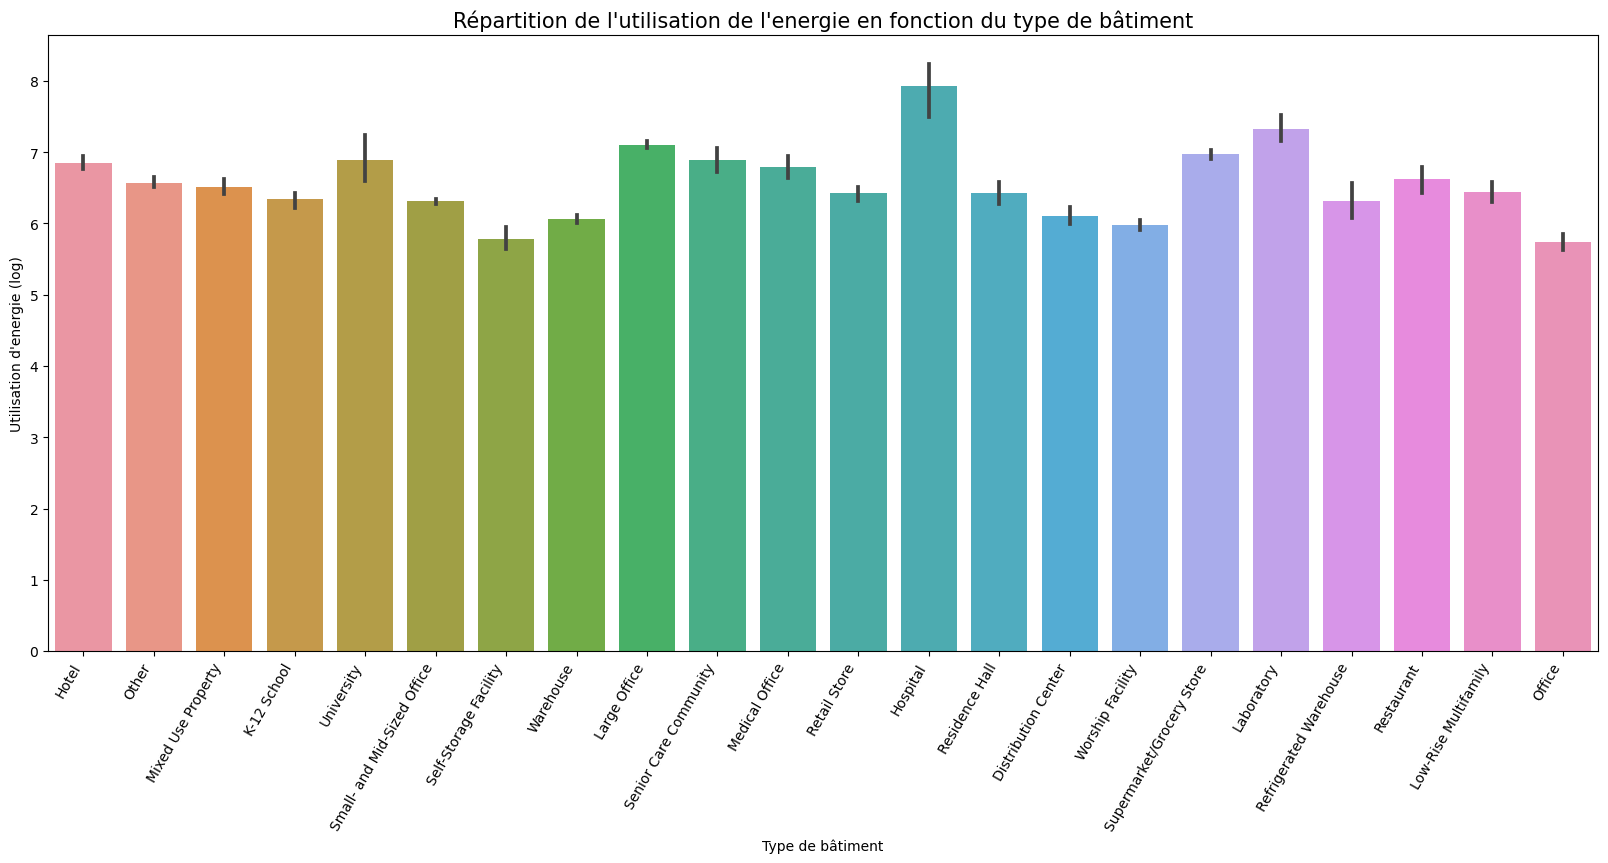

In [608]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(x="PrimaryPropertyType", y='SiteEnergyUse(kBtu)Log', data=data)

# Orienter les légendes
ax.set(xlabel="Type de bâtiment", ylabel="Utilisation d'energie (log)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.title("Répartition de l'utilisation de l'energie en fonction du type de bâtiment", fontsize=15)
plt.show()

In [609]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1633 entries, 0 to 3375
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   OSEBuildingID                         1633 non-null   int64   
 1   BuildingType                          1633 non-null   object  
 2   PrimaryPropertyType                   1633 non-null   object  
 3   TaxParcelIdentificationNumber         1633 non-null   object  
 4   Neighborhood                          1633 non-null   object  
 5   Latitude                              1633 non-null   float64 
 6   Longitude                             1633 non-null   float64 
 7   NumberofBuildings                     1633 non-null   float64 
 8   NumberofFloors                        1633 non-null   int64   
 9   PropertyGFATotal                      1633 non-null   int64   
 10  ListOfAllPropertyUseTypes             1633 non-null   object  
 11  LargestPr

None

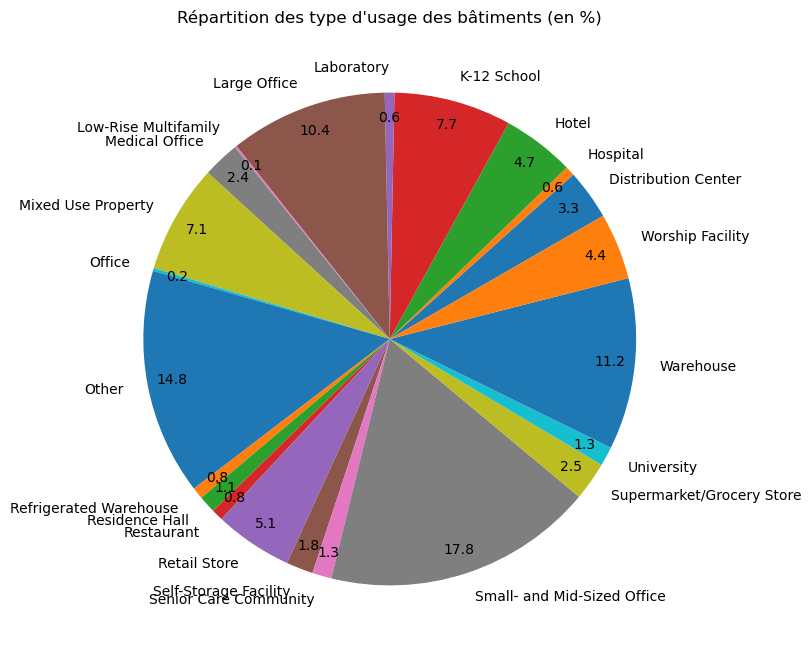

In [610]:
primaryType = data.groupby(by='PrimaryPropertyType')['TaxParcelIdentificationNumber'].nunique()
plt.figure(figsize=(22,8))
plt.pie(primaryType.values, labels = primaryType.index,
        autopct='%1.1f', startangle=30, textprops={'fontsize': 10}, pctdistance=0.9)
plt.title("Répartition des type d'usage des bâtiments (en %)", fontsize=12)
plt.show()

In [611]:
print(data["PrimaryPropertyType"].unique())


['Hotel' 'Other' 'Mixed Use Property' 'K-12 School' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'Large Office' 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital' 'Residence Hall' 'Distribution Center' 'Worship Facility'
 'Supermarket/Grocery Store' 'Laboratory' 'Refrigerated Warehouse'
 'Restaurant' 'Low-Rise Multifamily' 'Office']


In [612]:

# Créez un dictionnaire de mapping pour regrouper les catégories
mapping_dict = {
    'Hotel': 'Hospitality',
    'Other': 'Other',
    'Mixed Use Property': 'Mixed Use',
    'K-12 School': 'Education',
    'University': 'Education',
    'Small- and Mid-Sized Office': 'Office',
    'Self-Storage Facility': 'Storage',
    'Warehouse': 'Storage',
    'Large Office': 'Office',
    'Senior Care Community': 'Healthcare',
    'Medical Office': 'Healthcare',
    'Retail Store': 'Retail',
    'Hospital': 'Healthcare',
    'Residence Hall': 'Residential',
    'Distribution Center': 'Storage',
    'Worship Facility': 'Worship Facility',
    'Supermarket/Grocery Store': 'Retail',
    'Laboratory': 'Healthcare',
    'Refrigerated Warehouse': 'Storage',
    'Restaurant': 'Hospitality',
    'Low-Rise Multifamily': 'Residential',
    'Office': 'Office'
}

# Appliquez le mapping à la colonne 'PrimaryPropertyType'
data['PrimaryPropertyType'] = data['PrimaryPropertyType'].map(mapping_dict)

# Affichez les premières lignes du DataFrame résultant
print(data['PrimaryPropertyType'].head)


<bound method NDFrame.head of 0       Hospitality
1       Hospitality
2       Hospitality
3       Hospitality
4       Hospitality
           ...     
3371         Office
3372          Other
3373          Other
3374      Mixed Use
3375      Mixed Use
Name: PrimaryPropertyType, Length: 1633, dtype: object>


In [613]:
primaryType = data.groupby(by='PrimaryPropertyType')['TaxParcelIdentificationNumber'].nunique()
plt.figure(figsize=(12,6))
plt.pie(primaryType.values, labels = primaryType.index,
        autopct='%1.1f', startangle=30, textprops={'fontsize': 10}, pctdistance=0.9)
plt.title("Répartition des type d'usage des bâtiments (en %)", fontsize=12)
plt.show()

In [614]:
data.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], inplace = True)
#Exportation pour modélisation
data.reset_index(drop = True, inplace =True)
data.to_csv("building_energy_cleaned.csv")
data

OSEBuildingID        BuildingType PrimaryPropertyType  \
0                 1      NonResidential         Hospitality   
1                 2      NonResidential         Hospitality   
2                 3      NonResidential         Hospitality   
3                 5      NonResidential         Hospitality   
4                 8      NonResidential         Hospitality   
...             ...                 ...                 ...   
1628          50222  Nonresidential COS              Office   
1629          50223  Nonresidential COS               Other   
1630          50224  Nonresidential COS               Other   
1631          50225  Nonresidential COS           Mixed Use   
1632          50226  Nonresidential COS           Mixed Use   

     TaxParcelIdentificationNumber           Neighborhood  Latitude  \
0                       0659000030               DOWNTOWN  47.61220   
1                       0659000220               DOWNTOWN  47.61317   
2                       0659000475               DOWNTOWN  47.61393   
3                       0659000640               DOWNTOWN  47.61412   
4                       0659000970               DOWNTOWN  47.61375   
...                            ...                    ...       ...   
1628                    1624049080       GREATER DUWAMISH  47.56722   
1629                    3558300000               DOWNTOWN  47.59625   
1630                    1794501150  MAGNOLIA / QUEEN ANNE  47.63644   
1631                    7883603155       GREATER DUWAMISH  47.52832   
1632                    7857002030       GREATER DUWAMISH  47.53939   

      Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0    -122.33799                1.0              12             88434   
1    -122.33393                1.0              11            103566   
2    -122.33810                1.0              41            956110   
3    -122.33664                1.0              10             61320   
4    -122.34047                1.0              18            175580   
...         ...                ...             ...               ...   
1628 -122.31154                1.0               1             12294   
1629 -122.32283                1.0               1             16000   
1630 -122.35784                1.0               1             13157   
1631 -122.32431                1.0               1             14101   
1632 -122.29536                1.0               1             18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
1628                                             Office   
1629                                 Other - Recreation   
1630  Fitness Center/Health Club/Gym, Other - Recrea...   
1631  Fitness Center/Health Club/Gym, Food Service, ...   
1632  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType    SecondLargestPropertyUseType  \
0                     Hotel                  no information   
1                     Hotel                         Parking   
2                     Hotel                  no information   
3                     Hotel                  no information   
4                     Hotel                         Parking   
...                     ...                             ...   
1628                 Office                  no information   
1629     Other - Recreation                  no information   
1630     Other - Recreation  Fitness Center/Health Club/Gym   
1631     Other - Recreation  Fitness Center/Health Club/Gym   
1632     Other - Recreation  Fitness Center/Health Club/Gym   

     ThirdLargestPropertyUseType  ENERGYSTARScore  SourceEUI(kBtu

In [615]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   OSEBuildingID                         1633 non-null   int64   
 1   BuildingType                          1633 non-null   object  
 2   PrimaryPropertyType                   1633 non-null   object  
 3   TaxParcelIdentificationNumber         1633 non-null   object  
 4   Neighborhood                          1633 non-null   object  
 5   Latitude                              1633 non-null   float64 
 6   Longitude                             1633 non-null   float64 
 7   NumberofBuildings                     1633 non-null   float64 
 8   NumberofFloors                        1633 non-null   int64   
 9   PropertyGFATotal                      1633 non-null   int64   
 10  ListOfAllPropertyUseTypes             1633 non-null   object  
 11  Larg

In [616]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType',
       'TaxParcelIdentificationNumber', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus',
       'GHGEmissionsIntensity', 'BuildingAge', 'most_use_steam',
       'most_use_natural', 'most_use_electric', 'use_stream',
       'use_electricity', 'use_natural', 'percent_steam', 'percent_natural',
       'percent_electricity', 'LargestPropertyUseTypeGFA_rate',
       'SecondLargestPropertyUseTypeGFA_rate',
       'ThirdLargestPropertyUseTypeGFA_rate', 'PropertyGFABuilding(s)_rate',
       'PropertyGFAParking_rate', 'GFAPerBuilding', 'GFAPerFloor',
       'NumberOfAllUseTypes', 'TotalGHGEmissionsLog', 'SiteEnergy